In [1]:
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler


In [3]:
file_path = '../../Data/data_preprocessed/predicition_data/P_agg_data_for_prediction.csv'
# Read the CSV file into a DataFrame
dataset = pd.read_csv(file_path)
dataset

,measurement,appliance,value,timestamp
0,Electricity,P_agg,105.183,1661990400
1,Electricity,P_agg,105.224,1661990430
2,Electricity,P_agg,106.171,1661990460
3,Electricity,P_agg,105.903,1661990490
4,Electricity,P_agg,105.970,1661990520
...,...,...,...,...
1049313,Electricity,P_agg,1028.714,1693526250
1049314,Electricity,P_agg,1029.753,1693526280
1049315,Electricity,P_agg,1028.652,1693526310
1049316,Electricity,P_agg,1029.933,1693526340


In [4]:
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'], unit='s')
dataset = dataset.set_index("timestamp")

# Print the DataFrame or perform any desired operations
display(dataset)

,measurement,appliance,value
timestamp,,,
2022-09-01 00:00:00,Electricity,P_agg,105.183
2022-09-01 00:00:30,Electricity,P_agg,105.224
2022-09-01 00:01:00,Electricity,P_agg,106.171
2022-09-01 00:01:30,Electricity,P_agg,105.903
2022-09-01 00:02:00,Electricity,P_agg,105.970
...,...,...,...
2023-08-31 23:57:30,Electricity,P_agg,1028.714
2023-08-31 23:58:00,Electricity,P_agg,1029.753
2023-08-31 23:58:30,Electricity,P_agg,1028.652


In [5]:
import pandas as pd
import glob
import os

# Define folder path
folder_path = "../../Data/Plegma Dataset/Environmental_data/"

# Get all CSV or Excel files
file_pattern = os.path.join(folder_path, "*.*")
all_files = glob.glob(file_pattern)

# Define valid date range (2022-07 to 2023-08)
valid_months = pd.date_range(start="2022-07", end="2023-08", freq="MS").strftime("%Y-%m").tolist()

# Initialize list for temperature data
temperature_data = []

for file in all_files:
    filename = os.path.basename(file)
    if any(ym in filename for ym in valid_months):
        try:
            df = pd.read_csv(file) if file.endswith('.csv') else pd.read_excel(file)

            # Try to identify the correct temperature column
            if 'external_temperature' in df.columns:
                temp_df = df[['timestamp', 'external_temperature']].copy()
            elif 'external_temparature' in df.columns:
                temp_df = df[['timestamp', 'external_temparature']].copy()
                temp_df.rename(columns={'external_temparature': 'external_temperature'}, inplace=True)
            else:
                print(f"No temperature column found in {filename}")
                continue

            # Optional: Convert timestamp to datetime if needed
            temp_df['timestamp'] = pd.to_datetime(temp_df['timestamp'], errors='coerce')

            # Drop rows with missing timestamps
            temp_df.dropna(subset=['timestamp'], inplace=True)

            temperature_data.append(temp_df)

        except Exception as e:
            print(f"Error reading {filename}: {e}")

# Final concatenated DataFrame
if temperature_data:
    temperature_df = pd.concat(temperature_data, ignore_index=True)
    print(temperature_df.head())
    print(len(temperature_df), "rows of temperature data found.")
else:
    print("No temperature data found.")


            timestamp  external_temperature
0 2022-07-15 00:00:00                 25.03
1 2022-07-15 00:15:00                 25.06
2 2022-07-15 00:30:00                 25.09
3 2022-07-15 00:45:00                 25.12
4 2022-07-15 01:00:00                 25.15
39552 rows of temperature data found.


## BiGRU Approach

### 1day without features

In [11]:
one_day_dataset = dataset['value'].resample("1d").sum()
print(dataset.dtypes)
one_day_dataset

measurement     object
appliance       object
value          float64
dtype: object


timestamp
2022-09-01    1.075340e+06
2022-09-02    3.319990e+06
2022-09-03    2.197876e+06
2022-09-04    2.637342e+06
2022-09-05    3.367644e+05
                  ...     
2023-08-27    8.190875e+05
2023-08-28    1.783522e+06
2023-08-29    2.796125e+06
2023-08-30    2.478858e+06
2023-08-31    1.335031e+06
Freq: D, Name: value, Length: 365, dtype: float64

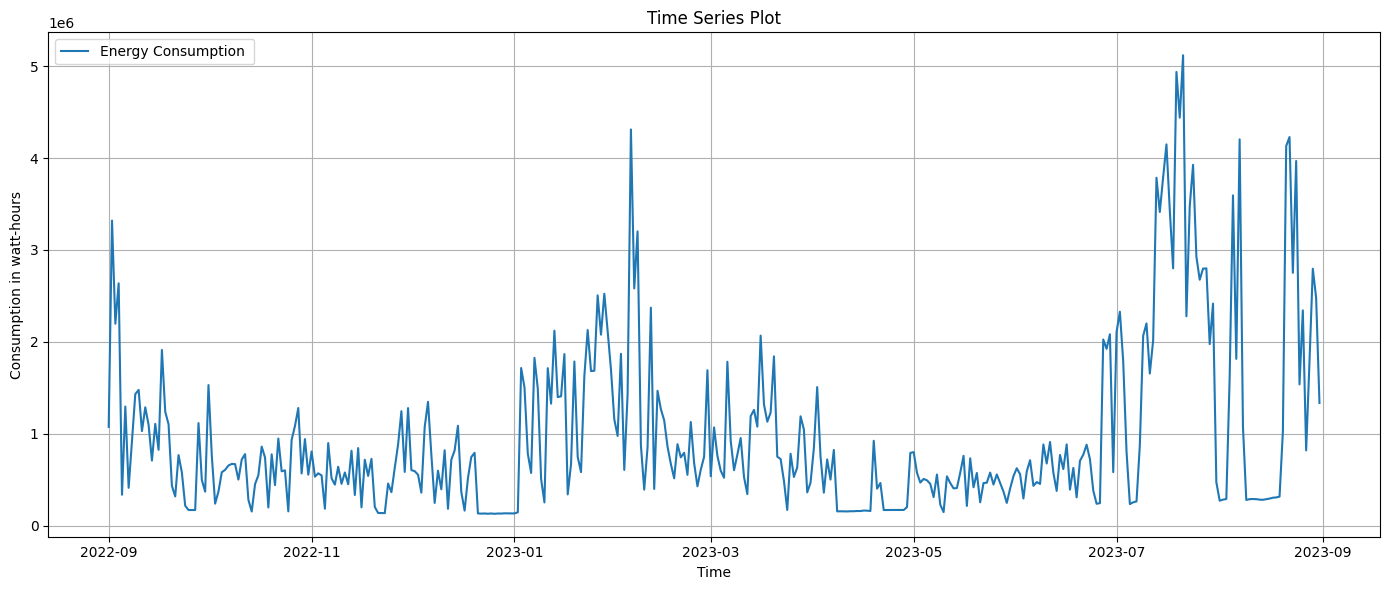

In [ ]:
# Convert to DataFrame
df = pd.DataFrame(one_day_dataset)
# Ensure the timestamp is in datetime format and set it as index

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['value'], label='Energy Consumption ')
plt.xlabel('Time')
plt.ylabel('Consumption in watt-hours')
plt.title('Time Series Plot')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [49]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()

X_scaled = scaler_X.fit_transform(one_day_dataset.values.reshape(-1, 1))

X_scaled

array([[1.89604950e-01],
       [6.39428803e-01],
       [4.14559179e-01],
       [5.02627317e-01],
       [4.15955951e-02],
       [2.33889309e-01],
       [5.66429573e-02],
       [1.57427347e-01],
       [2.61077038e-01],
       [2.70250109e-01],
       [1.80385014e-01],
       [2.32213768e-01],
       [1.93647289e-01],
       [1.16079236e-01],
       [1.96164471e-01],
       [1.39487903e-01],
       [3.57268028e-01],
       [2.22710517e-01],
       [1.95099968e-01],
       [6.12759212e-02],
       [3.78583987e-02],
       [1.28005673e-01],
       [9.00396669e-02],
       [1.76090644e-02],
       [8.21195080e-03],
       [8.14346620e-03],
       [8.20021638e-03],
       [1.97795768e-01],
       [7.37864912e-02],
       [4.83252606e-02],
       [2.80711207e-01],
       [1.26560109e-01],
       [2.21456026e-02],
       [4.84550601e-02],
       [9.05602006e-02],
       [9.58803544e-02],
       [1.05283426e-01],
       [1.08763481e-01],
       [1.08348307e-01],
       [7.46364735e-02],


In [12]:
# Split train data and test data
train_size = round(len(X_scaled)*0.6666)

# train_data = df.WC.loc[:train_size] -----> it gives a series
# Do not forget use iloc to select a number of rows
train_data = X_scaled[:train_size]
test_data = X_scaled[train_size:]

NameError: name 'X_scaled' is not defined

In [172]:
import numpy as np

def create_dataset (X, look_back = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
        
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(train_data,7)
X_test, y_test = create_dataset(test_data,7)

In [173]:
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)
     

X_train.shape:  (236, 7, 1)
y_train.shape:  (236, 1)
X_test.shape:  (115, 7, 1)
y_test.shape:  (115, 1)


In [174]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Dropout
from keras.regularizers import l2 
from tensorflow import keras
from keras.layers import LayerNormalization

from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, LayerNormalization
from keras.regularizers import l2


def create_gru(units):
    model = Sequential()
    # Input layer 
    model.add(GRU (units = units, return_sequences = True, 
                 input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.15)) 
    # Hidden layer
    model.add(GRU(units = 64))                 
    model.add(Dropout(0.15))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
   
    return model


def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.2,
                    batch_size = 16, shuffle = False, callbacks = [early_stop])
    return history


In [175]:
model_gru = create_gru(64)
history_gru = fit_model(model_gru)

Epoch 1/100
12/12 [==============================] - 2s 40ms/step - loss: 0.0157 - val_loss: 0.0156
Epoch 2/100
12/12 [==============================] - 0s 12ms/step - loss: 0.0159 - val_loss: 0.0064
Epoch 3/100
12/12 [==============================] - 0s 12ms/step - loss: 0.0120 - val_loss: 0.0071
Epoch 4/100
12/12 [==============================] - 0s 11ms/step - loss: 0.0119 - val_loss: 0.0061
Epoch 5/100
12/12 [==============================] - 0s 11ms/step - loss: 0.0116 - val_loss: 0.0062
Epoch 6/100
12/12 [==============================] - 0s 11ms/step - loss: 0.0116 - val_loss: 0.0062
Epoch 7/100
12/12 [==============================] - 0s 11ms/step - loss: 0.0119 - val_loss: 0.0059
Epoch 8/100
12/12 [==============================] - 0s 11ms/step - loss: 0.0119 - val_loss: 0.0062
Epoch 9/100
12/12 [==============================] - 0s 11ms/step - loss: 0.0117 - val_loss: 0.0059
Epoch 10/100
12/12 [==============================] - 0s 11ms/step - loss: 0.0112 - val_loss: 0.0061

In [176]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs(errors/actual))*100

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('Mean Absolute Percentage Error: {:.4f}'.format(mape))

evaluate_prediction(model_gru.predict(X_test),y_test, "GRU Model")

4/4 [==============================] - 0s 5ms/step
GRU Model:
Mean Absolute Error: 0.1201
Root Mean Square Error: 0.1771
Mean Absolute Percentage Error: 140.7667


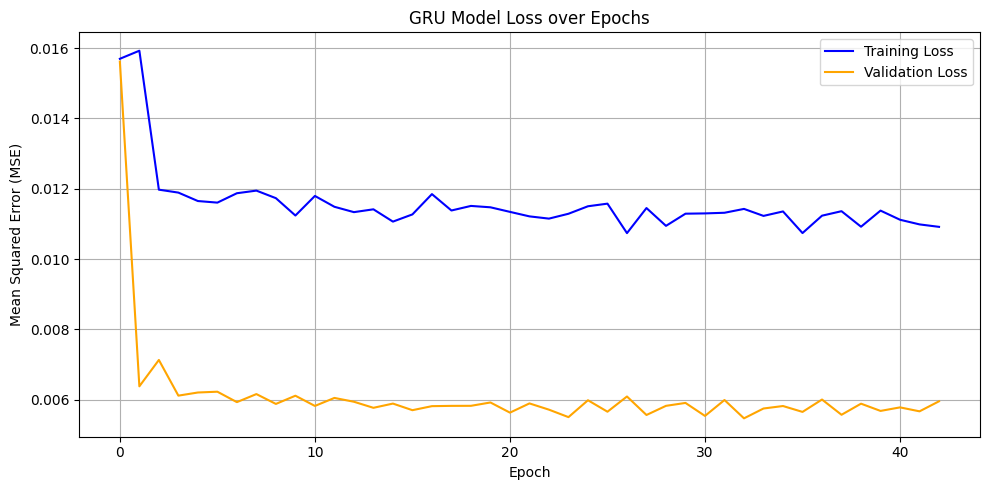

In [177]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history_gru.history['loss'], label='Training Loss', color='blue')
plt.plot(history_gru.history['val_loss'], label='Validation Loss', color='orange')
plt.title('GRU Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [178]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_X.inverse_transform(prediction)
    return prediction

# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Day')
    plt.ylabel('Electricity consumption')



4/4 [==============================] - 0s 4ms/step


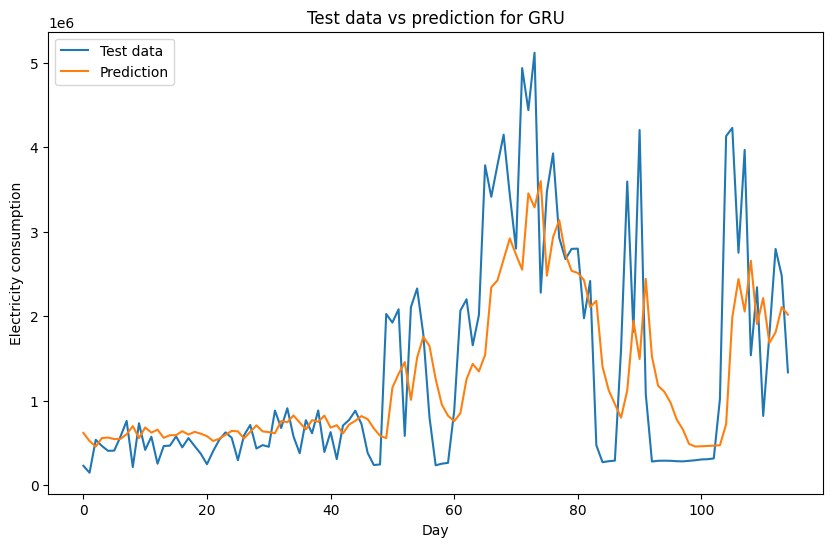

In [179]:
y_test_orig = scaler_X.inverse_transform(y_test)
y_train_orig = scaler_X.inverse_transform(y_train)

prediction_gru = prediction(model_gru)

plot_future(prediction_gru, 'GRU', y_test_orig)

### 1hour with features (temparture)

In [6]:
# Ensure 'timestamp' is datetime and set as index
temperature_df['timestamp'] = pd.to_datetime(temperature_df['timestamp'], errors='coerce')
temperature_df = temperature_df.set_index('timestamp')

# Resample to hourly frequency and compute the mean
df_temp_1d = temperature_df['external_temperature'].resample("1h").mean()

# Print data type and preview
print(len(df_temp_1d))
print(df_temp_1d.head())

9912
timestamp
2022-07-15 00:00:00    25.07500
2022-07-15 01:00:00    25.10500
2022-07-15 02:00:00    24.93625
2022-07-15 03:00:00    24.85500
2022-07-15 04:00:00    25.45250
Freq: h, Name: external_temperature, dtype: float64


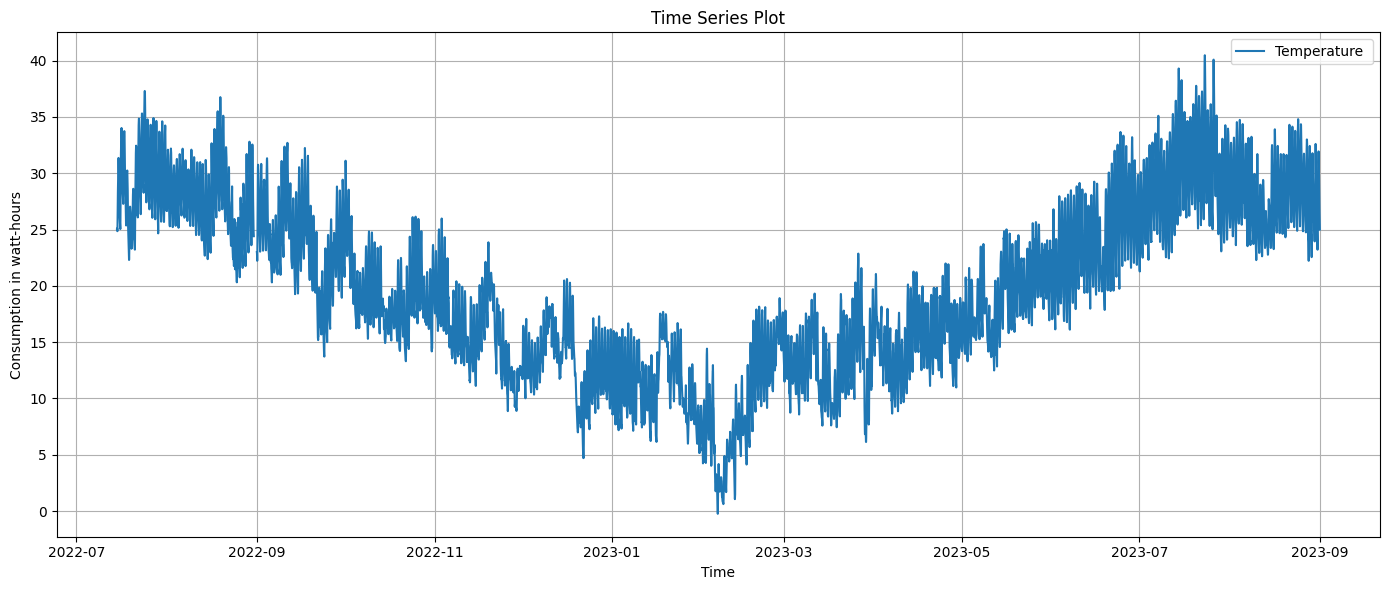

In [7]:
df = pd.DataFrame(df_temp_1d)
# Ensure the timestamp is in datetime format and set it as index

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df.index, df, label='Temperature ')
plt.xlabel('Time')
plt.ylabel('Consumption in watt-hours')
plt.title('Time Series Plot')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
one_day_dataset = dataset['value'].resample("1h").sum()
print(dataset.dtypes)
one_day_dataset

measurement     object
appliance       object
value          float64
dtype: object


timestamp
2022-09-01 00:00:00     12844.1820
2022-09-01 01:00:00     12888.4205
2022-09-01 02:00:00     12814.1450
2022-09-01 03:00:00     12801.2040
2022-09-01 04:00:00     12679.9390
                          ...     
2023-08-31 19:00:00     27067.0740
2023-08-31 20:00:00     23931.8450
2023-08-31 21:00:00     24318.5340
2023-08-31 22:00:00    102417.7910
2023-08-31 23:00:00    119334.4960
Freq: h, Name: value, Length: 8760, dtype: float64

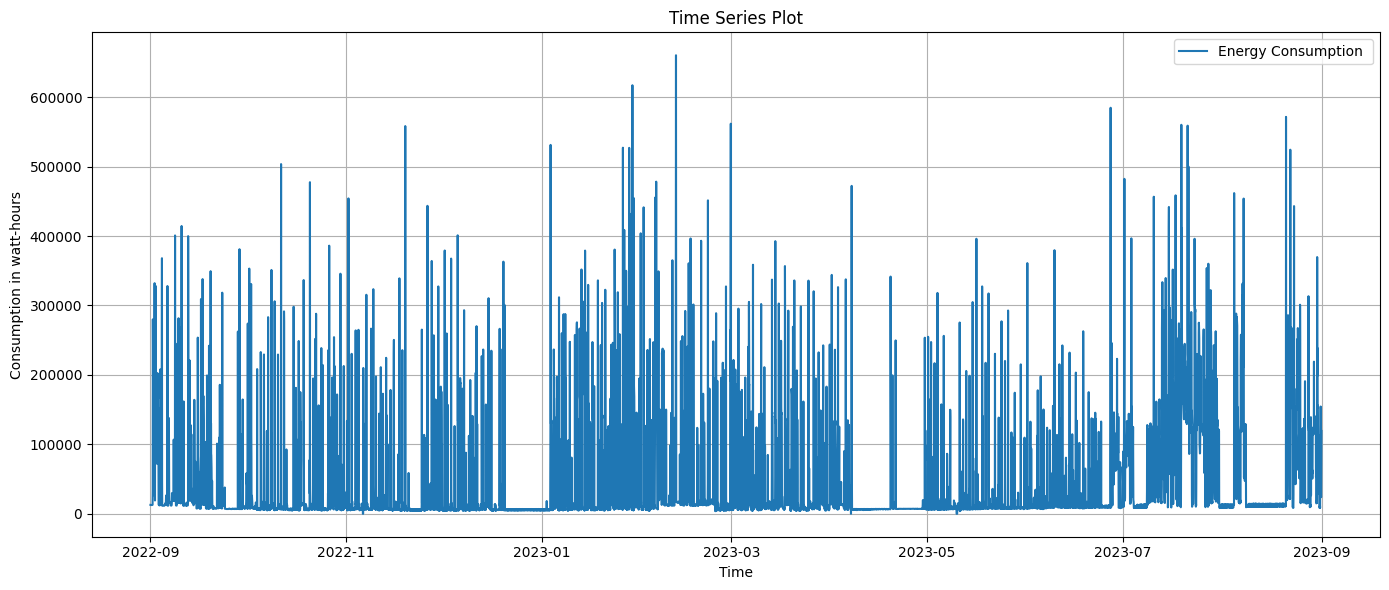

In [9]:
# Convert to DataFrame
df = pd.DataFrame(one_day_dataset)
# Ensure the timestamp is in datetime format and set it as index

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['value'], label='Energy Consumption ')
plt.xlabel('Time')
plt.ylabel('Consumption in watt-hours')
plt.title('Time Series Plot')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# Ensure both are pandas Series and indexed by datetime
one_day_dataset.index = pd.to_datetime(one_day_dataset.index)
df_temp_1d.index = pd.to_datetime(df_temp_1d.index)

# Join on common timestamps using inner join
aligned_df = one_day_dataset.to_frame(name='energy').join(
    df_temp_1d.to_frame(name='external_temperature'),
    how='inner'
)

print(aligned_df.head())


                         energy  external_temperature
timestamp                                            
2022-09-01 00:00:00  12844.1820              23.00125
2022-09-01 01:00:00  12888.4205              22.90125
2022-09-01 02:00:00  12814.1450              22.47000
2022-09-01 03:00:00  12801.2040              22.22375
2022-09-01 04:00:00  12679.9390              22.67250


In [11]:
aligned_df.dropna(inplace=True)
aligned_df

,energy,external_temperature
timestamp,,
2022-09-01 00:00:00,12844.1820,23.00125
2022-09-01 01:00:00,12888.4205,22.90125
2022-09-01 02:00:00,12814.1450,22.47000
2022-09-01 03:00:00,12801.2040,22.22375
2022-09-01 04:00:00,12679.9390,22.67250
...,...,...
2023-08-31 19:00:00,27067.0740,27.01250
2023-08-31 20:00:00,23931.8450,26.51250
2023-08-31 21:00:00,24318.5340,25.97500


In [12]:
# 3-hour, 6-hour, and 12-hour rolling averages
aligned_df['rolling_3h'] = aligned_df['energy'].rolling(window=3).mean()
aligned_df['rolling_6h'] = aligned_df['energy'].rolling(window=6).mean()
aligned_df['rolling_12h'] = aligned_df['energy'].rolling(window=12).mean()
aligned_df['hour'] = aligned_df.index.hour
aligned_df['dayofweek'] = aligned_df.index.dayofweek
aligned_df['month'] = aligned_df.index.month
aligned_df['is_weekend'] = aligned_df['dayofweek'] >= 5
# Create lag features for the past 24 to 72 hours
for lag in range(1, 73):  # 1 to 72 hour lags
    aligned_df[f'lag_{lag}'] = aligned_df['energy'].shift(lag)
aligned_df.dropna(inplace=True)
aligned_df


,energy,external_temperature,rolling_3h,rolling_6h,rolling_12h,hour,dayofweek,month,is_weekend,lag_1,...,lag_63,lag_64,lag_65,lag_66,lag_67,lag_68,lag_69,lag_70,lag_71,lag_72
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-09-04 00:00:00,12352.644,24.03625,12321.453333,33872.370500,23445.864250,0,6,9,True,12343.661,...,12608.9520,12645.4170,12601.857,12600.215,12595.513,12679.939,12801.204,12814.145,12888.4205,12844.1820
2022-09-04 01:00:00,180125.298,23.71500,68273.867667,45802.908500,37356.801833,1,6,9,True,12352.644,...,12608.2120,12608.9520,12645.417,12601.857,12600.215,12595.513,12679.939,12801.204,12814.1450,12888.4205
2022-09-04 02:00:00,208017.600,23.33500,133498.514000,72904.889333,53571.730917,2,6,9,True,180125.298,...,12610.4320,12608.2120,12608.952,12645.417,12601.857,12600.215,12595.513,12679.939,12801.2040,12814.1450
2022-09-04 03:00:00,183077.489,23.15625,190406.795667,101364.124500,67710.739250,3,6,9,True,208017.600,...,12601.1425,12610.4320,12608.212,12608.952,12645.417,12601.857,12600.215,12595.513,12679.9390,12801.2040
2022-09-04 04:00:00,166849.144,23.52875,185981.411000,127127.639333,80487.157917,4,6,9,True,183077.489,...,12732.5330,12601.1425,12610.432,12608.212,12608.952,12645.417,12601.857,12600.215,12595.5130,12679.9390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31 19:00:00,27067.074,27.01250,103469.803000,112501.878333,60973.015000,19,3,8,False,128864.074,...,79416.8010,50681.6980,63144.984,57263.588,95158.176,94461.916,71081.117,85906.980,106196.1470,116693.3760
2023-08-31 20:00:00,23931.845,26.51250,59954.331000,97646.782167,62245.725667,20,3,8,False,27067.074,...,114338.9450,79416.8010,50681.698,63144.984,57263.588,95158.176,94461.916,71081.117,85906.9800,106196.1470
2023-08-31 21:00:00,24318.534,25.97500,25105.817667,84260.209333,63563.282500,21,3,8,False,23931.845,...,119632.0710,114338.9450,79416.801,50681.698,63144.984,57263.588,95158.176,94461.916,71081.1170,85906.9800


In [14]:
from sklearn.preprocessing import MinMaxScaler

feature_cols = aligned_df.drop('energy', axis=1)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
print(feature_cols.columns.tolist())

X_scaled = scaler_X.fit_transform(feature_cols)
y_scaled = scaler_y.fit_transform(aligned_df[['energy']])
X_scaled

['external_temperature', 'rolling_3h', 'rolling_6h', 'rolling_12h', 'hour', 'dayofweek', 'month', 'is_weekend', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'lag_25', 'lag_26', 'lag_27', 'lag_28', 'lag_29', 'lag_30', 'lag_31', 'lag_32', 'lag_33', 'lag_34', 'lag_35', 'lag_36', 'lag_37', 'lag_38', 'lag_39', 'lag_40', 'lag_41', 'lag_42', 'lag_43', 'lag_44', 'lag_45', 'lag_46', 'lag_47', 'lag_48', 'lag_49', 'lag_50', 'lag_51', 'lag_52', 'lag_53', 'lag_54', 'lag_55', 'lag_56', 'lag_57', 'lag_58', 'lag_59', 'lag_60', 'lag_61', 'lag_62', 'lag_63', 'lag_64', 'lag_65', 'lag_66', 'lag_67', 'lag_68', 'lag_69', 'lag_70', 'lag_71', 'lag_72']


array([[0.59623592, 0.02617188, 0.08951106, ..., 0.01940544, 0.01951792,
        0.01945092],
       [0.58834546, 0.14501989, 0.12164165, ..., 0.01938584, 0.01940544,
        0.01951792],
       [0.579012  , 0.28356295, 0.19463105, ..., 0.0192022 , 0.01938584,
        0.01940544],
       ...,
       [0.64385496, 0.05332703, 0.22521251, ..., 0.14305088, 0.10764356,
        0.13009549],
       [0.62911793, 0.10667762, 0.20524572, ..., 0.14410528, 0.14305088,
        0.10764356],
       [0.61990728, 0.17422558, 0.18947121, ..., 0.08671862, 0.14410528,
        0.14305088]])

In [15]:
scaled_data = np.hstack((y_scaled, X_scaled))
scaled_data

array([[0.01870655, 0.59623592, 0.02617188, ..., 0.01940544, 0.01951792,
        0.01945092],
       [0.27277747, 0.58834546, 0.14501989, ..., 0.01938584, 0.01940544,
        0.01951792],
       [0.31501691, 0.579012  , 0.28356295, ..., 0.0192022 , 0.01938584,
        0.01940544],
       ...,
       [0.03682741, 0.64385496, 0.05332703, ..., 0.14305088, 0.10764356,
        0.13009549],
       [0.15509907, 0.62911793, 0.10667762, ..., 0.14410528, 0.14305088,
        0.10764356],
       [0.18071733, 0.61990728, 0.17422558, ..., 0.08671862, 0.14410528,
        0.14305088]])

In [12]:
# Split train data and test data
train_size = round(len(scaled_data)*0.6666)

# train_data = df.WC.loc[:train_size] -----> it gives a series
# Do not forget use iloc to select a number of rows
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [13]:
import numpy as np

def create_daily_dataset(data, look_back=7):
    Xs, ys = [], []

    for i in range(len(data) - look_back):
        X_seq = data[i:i+look_back]      # shape: (look_back, features)
        y_target = data[i+look_back, 0]  # predict next day's energy (column 0)
        Xs.append(X_seq)
        ys.append(y_target)

    return np.array(Xs), np.array(ys)

X_train, y_train = create_daily_dataset(train_data, look_back=25)
X_test, y_test = create_daily_dataset(test_data,25)
y_test

array([0.01655807, 0.00924611, 0.00954399, ..., 0.03682741, 0.15509907,
       0.18071733])

In [14]:
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)
     

X_train.shape:  (5766, 25, 81)
y_train.shape:  (5766,)
X_test.shape:  (2872, 25, 81)
y_test.shape:  (2872,)


In [15]:
import tensorflow as tf
# Set random seed to get the same result after each time running the code
tf.random.set_seed(1234)


In [24]:

from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.callbacks import EarlyStopping


def create_gru(input_shape,units):
    model = Sequential()
    
    # Input GRU layer (returns sequences for stacking)
    model.add(GRU(units, activation='relu', input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    
    # Second GRU layer (no sequences returned)
    model.add(GRU(units, activation='relu'))
    model.add(Dropout(0.2))
    
    # Output layer: predict next day's energy consumption (scalar)
    model.add(Dense(units=24))
    
    model.compile(optimizer='adam', loss='mse')
    return model

def fit_model(model):
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = model.fit(X_train, y_train, 
                        epochs=100, 
                        batch_size=64, 
                        validation_split=0.2, 
                        shuffle=False,
                        callbacks=[early_stop])
    return history


In [25]:

# Create model
input_shape = X_train.shape[1:]  # (25, 81)
model_gru = create_gru(input_shape, units=64)

# Fit model
history = fit_model(model_gru)

Epoch 1/100
73/73 [==============================] - 12s 121ms/step - loss: 0.0120 - val_loss: 0.0059
Epoch 2/100
73/73 [==============================] - 11s 144ms/step - loss: 0.0110 - val_loss: 0.0059
Epoch 3/100
73/73 [==============================] - 11s 146ms/step - loss: 0.0107 - val_loss: 0.0057
Epoch 4/100
73/73 [==============================] - 12s 166ms/step - loss: 0.0104 - val_loss: 0.0055
Epoch 5/100
73/73 [==============================] - 13s 181ms/step - loss: 0.0101 - val_loss: 0.0054
Epoch 6/100
73/73 [==============================] - 13s 172ms/step - loss: 0.0098 - val_loss: 0.0053
Epoch 7/100
73/73 [==============================] - 11s 146ms/step - loss: 0.0095 - val_loss: 0.0052
Epoch 8/100
73/73 [==============================] - 11s 148ms/step - loss: 0.0093 - val_loss: 0.0051
Epoch 9/100
73/73 [==============================] - 11s 145ms/step - loss: 0.0090 - val_loss: 0.0051
Epoch 10/100
73/73 [==============================] - 11s 149ms/step - loss: 0.008

In [26]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs(errors/actual))*100

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('Mean Absolute Percentage Error: {:.4f}'.format(mape))
# Compare predictions to the first 24 columns of y_test (adjust if needed)
evaluate_prediction(model_gru.predict(X_test), y_test[:24], "GRU Model")

90/90 [==============================] - 4s 40ms/step
GRU Model:
Mean Absolute Error: 0.0414
Root Mean Square Error: 0.0633
Mean Absolute Percentage Error: 366.5005


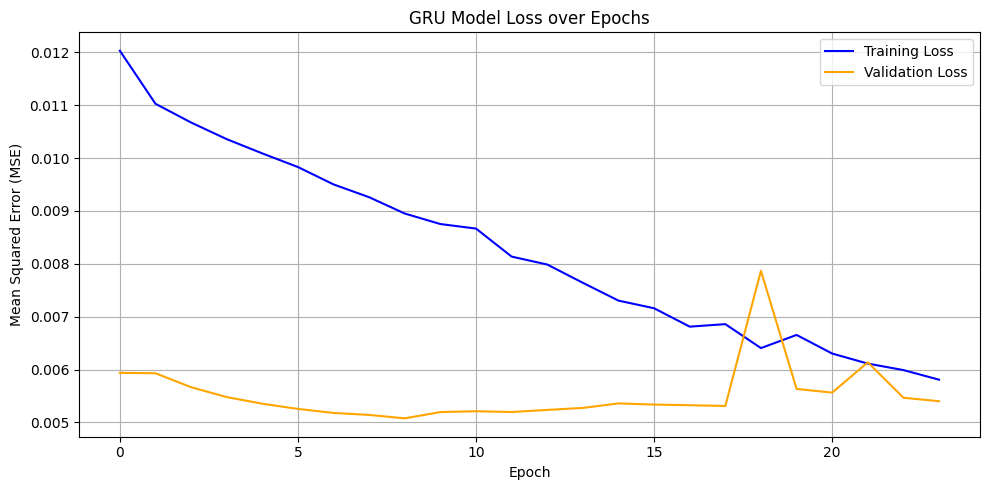

In [27]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('GRU Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
from sklearn.preprocessing import MinMaxScaler

def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction


def plot_future(prediction, model_name, y_test, feature_index=0):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    
    plt.plot(np.arange(range_future), y_test[:, feature_index], label='Test data')
    plt.plot(np.arange(range_future), prediction[:, feature_index], label='Prediction')

    plt.title(f'Test data vs prediction for {model_name} model')
    plt.legend(loc='upper left')
    plt.xlabel('Day')
    plt.ylabel('Electricity consumption')
    plt.grid(True)
    plt.show()




90/90 [==============================] - 3s 38ms/step


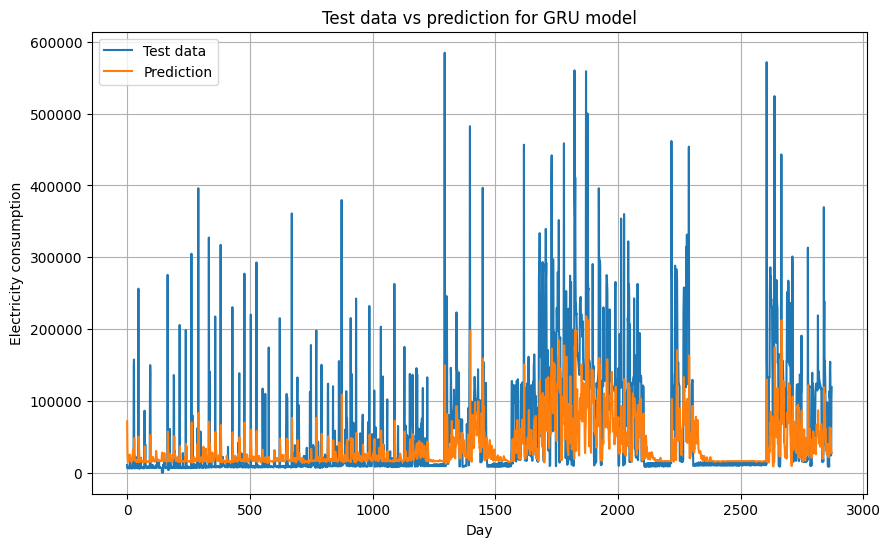

In [29]:
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_train_orig = scaler_y.inverse_transform(y_train.reshape(-1, 1))

# If prediction_gru is 1D, reshape it before inverse_transform
prediction_gru = prediction(model_gru)

plot_future(prediction_gru, 'GRU', y_test_orig, feature_index=0)

#### Optimization

In [18]:
import numpy as np

def create_sequences(data, look_back, horizon):
    """
    Creates input sequences (X) and future target sequences (y) for time series forecasting.
    
    Args:
        data (np.array): The dataset, with the target variable as the first column.
        look_back (int): The number of previous time steps to use as input features.
        horizon (int): The number of future time steps to predict.
        
    Returns:
        tuple: A tuple containing:
            - np.array: The input sequences (X). Shape: (samples, look_back, features).
            - np.array: The target sequences (y). Shape: (samples, horizon).
    """
    Xs, ys = [], []
    
    # The loop needs to stop early to ensure there are enough future data points for the horizon
    for i in range(len(data) - look_back - horizon + 1):
        # Input sequence (the past)
        X_seq = data[i : (i + look_back)]
        
        # Output sequence (the future)
        # We only want the first column (consumption) for the target
        y_seq = data[i + look_back : i + look_back + horizon, 0]
        
        Xs.append(X_seq)
        ys.append(y_seq)
        
    return np.array(Xs), np.array(ys)

In [ ]:
import numpy as np
# Assume 'scaled_data' is your full preprocessed and scaled DataFrame/Numpy array
# Assume the first column of scaled_data is the target 'WC' (consumption)

# --- 1. Define Constants ---
LOOK_BACK = 24  # Use the last 72 hours (3 days) of data to predict. This is a good starting point.
HORIZON = 24    # Predict the next 24 hours.

# --- 2. Create Sequences from the ENTIRE Dataset ---
# This is more efficient and avoids the "gap" problem.
X, y = create_sequences(scaled_data, look_back=LOOK_BACK, horizon=HORIZON)
print(f"Shape of X: {X.shape}") # Should be (num_samples, 72, num_features)
print(f"Shape of y: {y.shape}") # Should be (num_samples, 24)

# --- 3. Split the SEQUENCES into Train, Validation, and Test Sets ---
# This is the correct way to split time-ordered data.
total_samples = len(X)
train_size = int(total_samples * 0.7)
val_size = int(total_samples * 0.15)
test_size = total_samples - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size : train_size + val_size], y[train_size : train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

print("\nData Shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")

# Now you have X_train, y_train, X_val, y_val, and X_test, y_test
# ready to be used with the optimized GRU model from the previous answer.
#
# Example usage:
# model = create_gru_v2(input_shape=(LOOK_BACK, X_train.shape[2]))
# history = fit_model_v2(model, X_train, y_train, X_val, y_val)

Shape of X: (8653, 12, 81)
Shape of y: (8653, 24)

Data Shapes:
X_train: (6057, 12, 81), y_train: (6057, 24)
X_val:   (1297, 12, 81), y_val:   (1297, 24)
X_test:  (1299, 12, 81), y_test:  (1299, 24)


In [78]:
import tensorflow as tf
from keras.models import Model
from keras.layers import GRU, Dense, Dropout, BatchNormalization, Attention, Input, Add
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.regularizers import l1_l2
from keras.optimizers import Adam
from keras.models import Sequential
import keras.backend as K

def asymmetric_mse_loss(y_true, y_pred):
    """
    Penalizes under-prediction more severely than over-prediction.
    Especially useful for capturing peaks.
    """
    error = y_true - y_pred
    # You can tune the 'penalty_weight'. A higher value makes under-prediction more costly.
    penalty_weight = 2.5 
    
    # Apply penalty only when the prediction is lower than the true value (error > 0)
    loss = K.mean(K.square(error) * K.cast(K.greater(error, 0), 'float32') * penalty_weight +
                  K.square(error) * K.cast(K.less_equal(error, 0), 'float32'))
    
    return loss

def create_advanced_gru(input_shape, units=192):

    model = Sequential()
    
    # Input GRU layer with standard 'tanh' activation
    # 'tanh' is the default, but we'll be explicit for clarity
    model.add(GRU(units, activation='tanh', input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    
    # Second GRU layer
    model.add(GRU(units, activation='tanh'))
    model.add(Dropout(0.2))
    
    # Output layer
    model.add(Dense(units=24)) # Predicts all 24 hours at once
    
    # Use Adam optimizer with a slightly lower learning rate
    optimizer = Adam(learning_rate=0.001)
    
    # Compile with Mean Squared Error (we'll discuss alternatives later)
    model.compile(optimizer=optimizer, loss=asymmetric_mse_loss)
    return model




def fit_model_v2(model, X_train_data, y_train_data, X_val_data, y_val_data):
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
    
    history = model.fit(X_train_data, y_train_data, 
                        epochs=100, 
                        batch_size=64, 
                        validation_data=(X_val_data, y_val_data), # Use the explicit validation set
                        shuffle=False, # Essential for time series
                        callbacks=[early_stop])
    return history




In [79]:
model = create_advanced_gru(input_shape=(X_train.shape[1], X_train.shape[2]), units=128)
model.summary()
history = fit_model_v2(model, X_train, y_train, X_val, y_val)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_16 (GRU)                (None, 12, 128)           81024     
                                                                 
 dropout_16 (Dropout)        (None, 12, 128)           0         
                                                                 
 gru_17 (GRU)                (None, 128)               99072     
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 24)                3096      
                                                                 
Total params: 183,192
Trainable params: 183,192
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
95/95 [=============================

In [73]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs(errors/actual))*100

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('Mean Absolute Percentage Error: {:.4f}'.format(mape))
# Compare predictions to the first 24 columns of y_test (adjust if needed)
evaluate_prediction(model.predict(X_test), y_test, "GRU Model")

41/41 [==============================] - 1s 8ms/step
GRU Model:
Mean Absolute Error: 0.0933
Root Mean Square Error: 0.1407
Mean Absolute Percentage Error: 135.3007


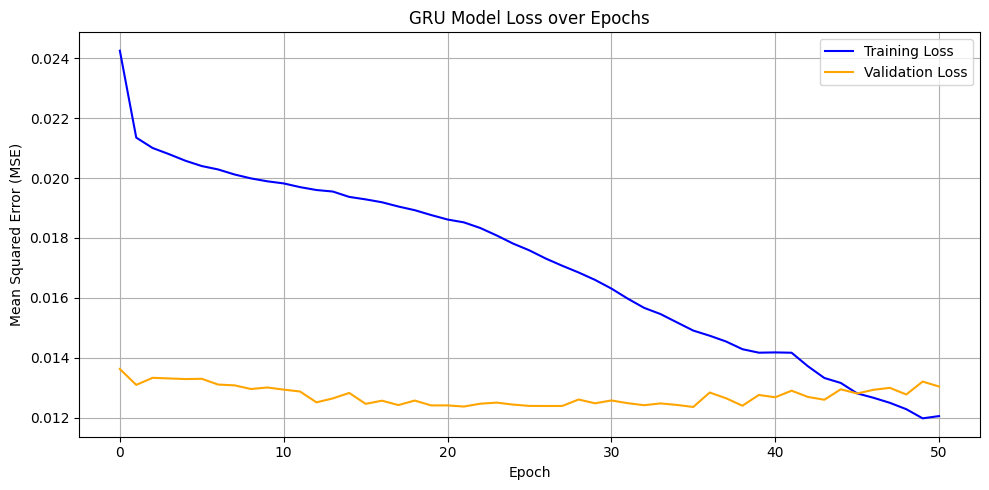

In [74]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('GRU Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [75]:
from sklearn.preprocessing import MinMaxScaler

def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction


def plot_future(prediction, model_name, y_test, feature_index=0):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    
    plt.plot(np.arange(range_future), y_test[:, feature_index], label='Test data')
    plt.plot(np.arange(range_future), prediction[:, feature_index], label='Prediction')

    plt.title(f'Test data vs prediction for {model_name} model')
    plt.legend(loc='upper left')
    plt.xlabel('Day')
    plt.ylabel('Electricity consumption')
    plt.grid(True)
    plt.show()




41/41 [==============================] - 0s 8ms/step


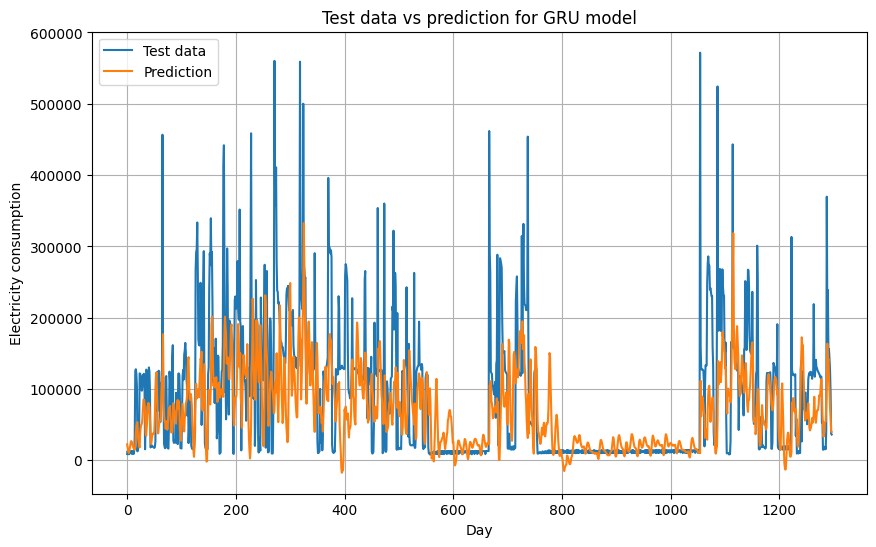

In [76]:
y_test_orig = scaler_y.inverse_transform(y_test)
y_train_orig = scaler_y.inverse_transform(y_train.reshape(-1, 1))

# If prediction_gru is 1D, reshape it before inverse_transform
prediction_gru = prediction(model)

plot_future(prediction_gru, 'GRU', y_test_orig, feature_index=0)

## Half a day data preprocessing 

In [ ]:
one_day_dataset = dataset['value'].resample("12h").mean()
print(dataset.dtypes)
one_day_dataset

measurement     object
appliance       object
value          float64
dtype: object


timestamp
2022-09-01 00:00:00     105.762839
2022-09-01 12:00:00     641.446831
2022-09-02 00:00:00     823.615931
2022-09-02 12:00:00    1481.932748
2022-09-03 00:00:00    1314.393972
                          ...     
2023-08-29 12:00:00    1115.384392
2023-08-30 00:00:00     615.424898
2023-08-30 12:00:00    1106.004588
2023-08-31 00:00:00     257.045014
2023-08-31 12:00:00     670.059646
Freq: 12h, Name: value, Length: 730, dtype: float64

(array([19236., 19297., 19358., 19417., 19478., 19539., 19601.]),
 [Text(19236.0, 0, '2022-09-01 00:00:00'),
  Text(19297.0, 0, '2022-11-01 00:00:00'),
  Text(19358.0, 0, '2023-01-01 00:00:00'),
  Text(19417.0, 0, '2023-03-01 00:00:00'),
  Text(19478.0, 0, '2023-05-01 00:00:00'),
  Text(19539.0, 0, '2023-07-01 00:00:00'),
  Text(19601.0, 0, '2023-09-01 00:00:00')])

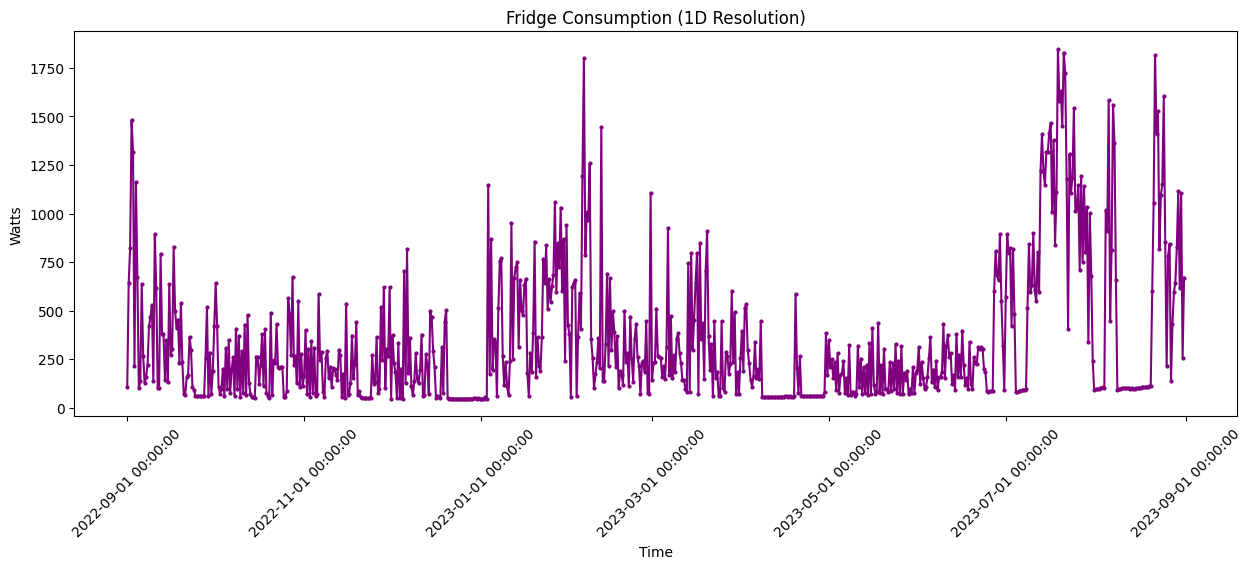

In [ ]:
import matplotlib.dates as mdates
plt.figure(figsize=(15, 5))
plt.plot(one_day_dataset.index, one_day_dataset, linestyle='-', marker='o', markersize=2, color='purple')
plt.title('Fridge Consumption (1D Resolution)')
plt.xlabel('Time')
plt.ylabel('Watts')
# Format x-axis to show date and time
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.xticks(rotation=45)

In [ ]:
print("Old Dataset: ", dataset.shape)
print("New Dataset: ", one_day_dataset.shape)

Old Dataset:  (1049318, 3)
New Dataset:  (730,)


In [ ]:
one_day_dataset

timestamp
2022-09-01 00:00:00     105.762839
2022-09-01 12:00:00     641.446831
2022-09-02 00:00:00     823.615931
2022-09-02 12:00:00    1481.932748
2022-09-03 00:00:00    1314.393972
                          ...     
2023-08-29 12:00:00    1115.384392
2023-08-30 00:00:00     615.424898
2023-08-30 12:00:00    1106.004588
2023-08-31 00:00:00     257.045014
2023-08-31 12:00:00     670.059646
Freq: 12h, Name: value, Length: 730, dtype: float64

In [ ]:
scaler = MinMaxScaler(feature_range = (0,1)) 
# reshape: convert the univariate 1D array into 2D
x = scaler.fit_transform(np.array(one_day_dataset).reshape(-1,1))
print("Normalizing data before model fitting")
print(x[:10])


Normalizing data before model fitting
[[0.03395694]
 [0.33094241]
 [0.43193772]
 [0.79691135]
 [0.70402715]
 [0.09280486]
 [0.61867077]
 [0.34735677]
 [0.03041691]
 [0.04988152]]


In [ ]:
# Better split for small dataset - maximize training data
training_size = int(len(x) * 0.85)  # 85% for training
val_size = int(len(x) * 0.10)      # 10% for validation  
test_size = len(x) - training_size - val_size  # 5% for testing

# Sequential split (important for time series)
train_data = x[0:training_size, :]
val_data = x[training_size:training_size + val_size, :]
test_data = x[training_size + val_size:, :]

print(f"Total samples: {len(x)}")
print(f"Training samples: {training_size}")
print(f"Validation samples: {val_size}")
print(f"Test samples: {test_size}")

Total samples: 730
Training samples: 620
Validation samples: 73
Test samples: 37


In [ ]:
# building input variable
def create_dataset(dataset, time_step = 5):
  dataX, dataY = [] , []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i + time_step,0])
  return np.array(dataX), np.array(dataY)


In [ ]:
timestep =30
X_train, y_train = create_dataset(train_data, timestep)
X_test, ytest = create_dataset(test_data)
X_val, yval = create_dataset(val_data, timestep)

print("X_train shape: ", X_train.shape)
print("X_test shape: ",X_test.shape)
print("X_val shape: ",X_val.shape)


X_train shape:  (589, 30)
X_test shape:  (31, 5)
X_val shape:  (42, 30)


In [ ]:
# reshape train and input-output pairs
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1],1)

print("X_train shape: ", X_train.shape)
print("X_test shape: ",X_test.shape)
print("X_val shape: ",X_val.shape)


X_train shape:  (589, 30, 1)
X_test shape:  (31, 5, 1)
X_val shape:  (42, 30, 1)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam

# Optimized model for small dataset (203 samples)
model = Sequential()

# First GRU layer - reduced units to prevent overfitting
model.add(GRU(units=32, return_sequences=True, input_shape=(timestep, 1), 
              kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second GRU layer - smaller
model.add(GRU(units=16, return_sequences=False, 
              kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Dense layers - minimal complexity
model.add(Dense(units=8, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Optimized optimizer with lower learning rate
optimizer = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(optimizer=optimizer, loss='huber', metrics=['mae'])


model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_80 (GRU)                (None, 30, 32)            3360      
                                                                 
 batch_normalization_20 (Bat  (None, 30, 32)           128       
 chNormalization)                                                
                                                                 
 dropout_90 (Dropout)        (None, 30, 32)            0         
                                                                 
 gru_81 (GRU)                (None, 16)                2400      
                                                                 
 batch_normalization_21 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 dropout_91 (Dropout)        (None, 16)              

In [ ]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_80 (GRU)                (None, 30, 32)            3360      
                                                                 
 batch_normalization_20 (Bat  (None, 30, 32)           128       
 chNormalization)                                                
                                                                 
 dropout_90 (Dropout)        (None, 30, 32)            0         
                                                                 
 gru_81 (GRU)                (None, 16)                2400      
                                                                 
 batch_normalization_21 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 dropout_91 (Dropout)        (None, 16)              

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# More aggressive early stopping for small dataset
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,  # More patience for small dataset
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=8,
    min_lr=1e-6,
    verbose=1
)

# Training with smaller batch size
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, yval),
    epochs=100,  # More epochs for small dataset
    batch_size=16,  # Smaller batch size
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
37/37 [==============================] - 3s 29ms/step - loss: 0.4238 - mae: 0.6462 - val_loss: 0.1670 - val_mae: 0.2816 - lr: 5.0000e-04
Epoch 2/100
37/37 [==============================] - 1s 15ms/step - loss: 0.2858 - mae: 0.4618 - val_loss: 0.1626 - val_mae: 0.2844 - lr: 5.0000e-04
Epoch 3/100
37/37 [==============================] - 1s 14ms/step - loss: 0.2571 - mae: 0.4236 - val_loss: 0.1487 - val_mae: 0.2669 - lr: 5.0000e-04
Epoch 4/100
37/37 [==============================] - 1s 14ms/step - loss: 0.2220 - mae: 0.3865 - val_loss: 0.1424 - val_mae: 0.2587 - lr: 5.0000e-04
Epoch 5/100
37/37 [==============================] - 0s 13ms/step - loss: 0.1956 - mae: 0.3505 - val_loss: 0.1311 - val_mae: 0.2433 - lr: 5.0000e-04
Epoch 6/100
37/37 [==============================] - 1s 14ms/step - loss: 0.1872 - mae: 0.3395 - val_loss: 0.1233 - val_mae: 0.2355 - lr: 5.0000e-04
Epoch 7/100
37/37 [==============================] - 1s 14ms/step - loss: 0.1581 - mae: 0.2852 - val_loss:

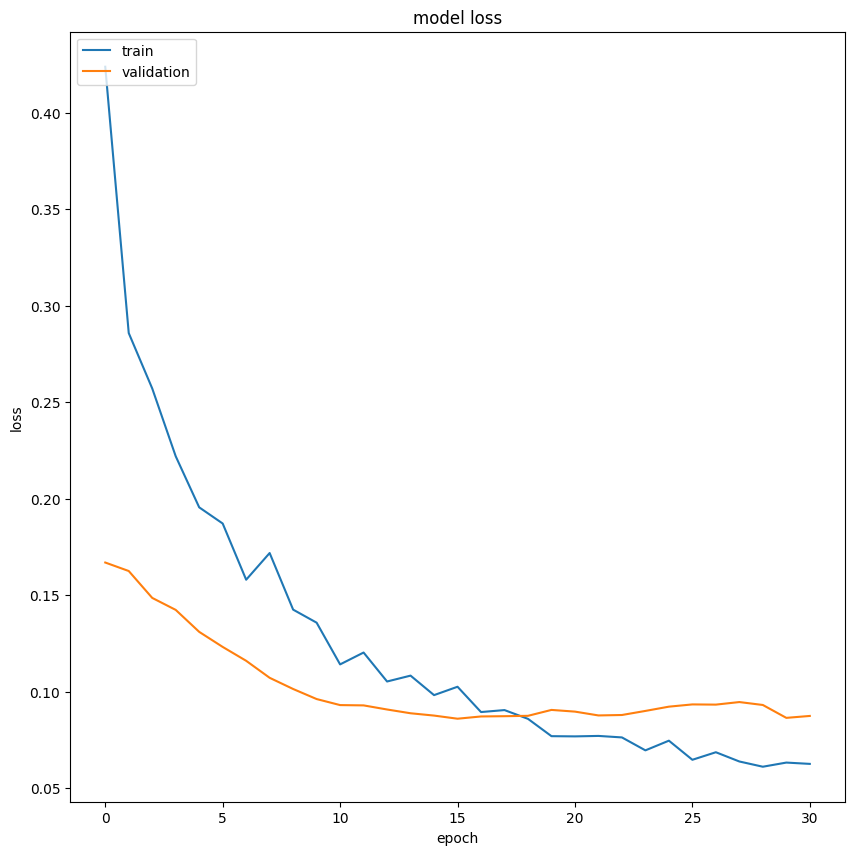

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss']) # tb
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
val_predict=model.predict(X_val)

2/2 [==============================] - 0s 6ms/step


In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
val_predict=scaler.inverse_transform(val_predict)

In [ ]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

312.96730069880084

In [ ]:
print(train_predict.shape)
print(test_predict.shape)
print(val_predict.shape)
print(train_predict[0])
print(y_train.shape)


(589, 1)
(31, 1)
(42, 1)
[308.18967]
(589,)


In [ ]:
# Predicting consumption using training data
train_predictions = model.predict(X_train)
train_predictions =scaler.inverse_transform(train_predictions)

y_train = y_train.reshape(y_train.shape[0], 1)
actual = scaler.inverse_transform(y_train)
train_results = pd.DataFrame()

train_results["Train Predictions"] = train_predictions.tolist()
train_results["Actuals"] = actual.tolist()

train_results

19/19 [==============================] - 0s 6ms/step


,Train Predictions,Actuals
0,[308.1896667480469],[272.41915092592586]
1,[304.45159912109375],[300.67336874999995]
2,[272.1817626953125],[828.92633125]
3,[433.0780334472656],[498.84442916666666]
4,[469.4536437988281],[407.96848958333334]
...,...,...
584,[473.5523376464844],[79.091275]
585,[384.46722412109375],[84.13941458333333]
586,[251.4553680419922],[87.82815138888888]
587,[125.53173065185547],[88.62544722222222]


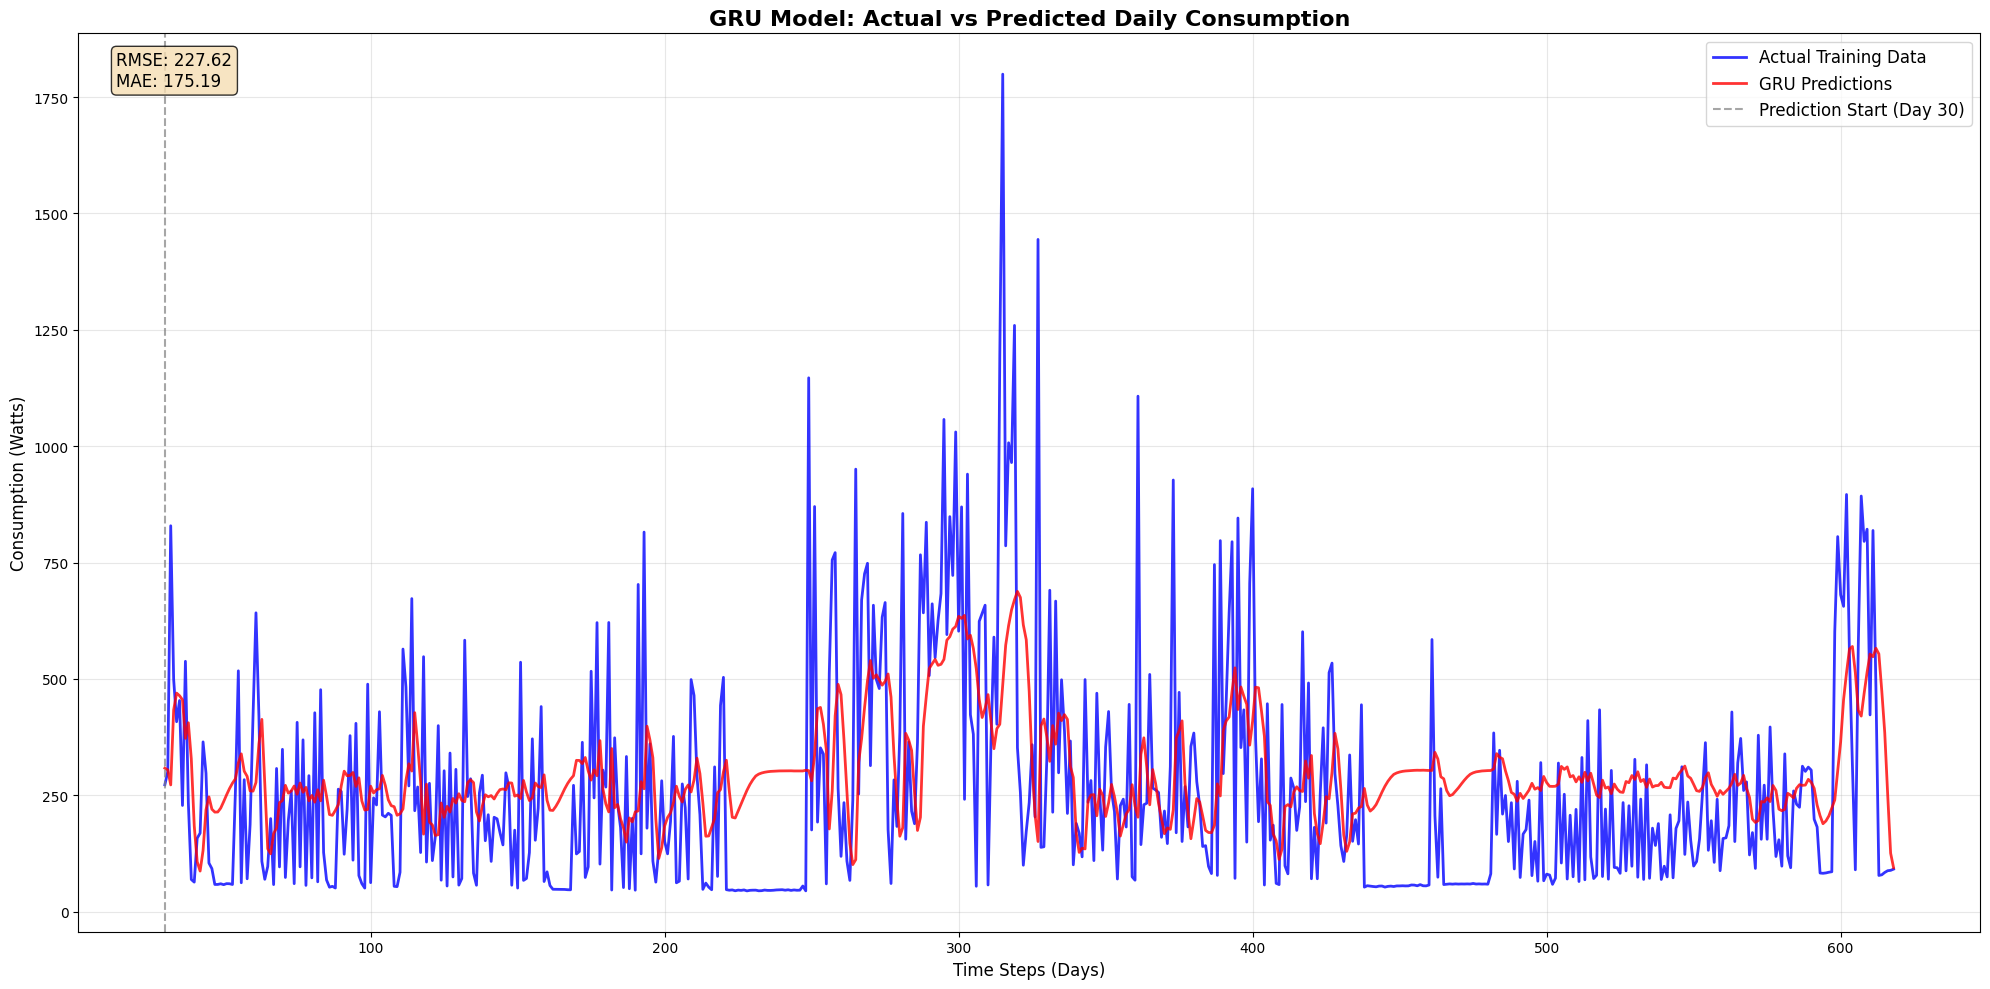


GRU MODEL PERFORMANCE METRICS
Training Data Points: 589
Time Steps Used: 30 days
RMSE: 227.6247 Watts
MAE: 175.1924 Watts
Mean Actual Consumption: 260.0687 Watts
Mean Predicted Consumption: 295.0531 Watts
R² Score: 0.1284


In [ ]:
plt.figure(figsize=(20, 10))

# Calculate the correct starting index based on timestep
start_idx = timestep  # 30 days offset due to timestep

# Create proper time-aligned plots
# Actual values (offset by timestep)
actual_full = np.full(len(x), np.nan)
actual_full[start_idx:start_idx + len(actual)] = actual.flatten()

# Predicted values (offset by timestep)
predictions_full = np.full(len(x), np.nan)
predictions_full[start_idx:start_idx + len(train_predictions)] = train_predictions.flatten()

# Plot the data
plt.plot(actual_full, label='Actual Training Data', color='blue', linewidth=2, alpha=0.8)
plt.plot(predictions_full, label='GRU Predictions', color='red', linewidth=2, alpha=0.8)

# Add vertical line to show where predictions start
plt.axvline(x=start_idx, color='gray', linestyle='--', alpha=0.7, label=f'Prediction Start (Day {start_idx})')

# Formatting
plt.title('GRU Model: Actual vs Predicted Daily Consumption', fontsize=16, fontweight='bold')
plt.xlabel('Time Steps (Days)', fontsize=12)
plt.ylabel('Consumption (Watts)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Add performance metrics as text
rmse = np.sqrt(mean_squared_error(actual, train_predictions))
mae = np.mean(np.abs(actual - train_predictions))
plt.text(0.02, 0.98, f'RMSE: {rmse:.2f}\nMAE: {mae:.2f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# Print detailed statistics
print(f"\n{'='*60}")
print(f"GRU MODEL PERFORMANCE METRICS")
print(f"{'='*60}")
print(f"Training Data Points: {len(actual)}")
print(f"Time Steps Used: {timestep} days")
print(f"RMSE: {rmse:.4f} Watts")
print(f"MAE: {mae:.4f} Watts")
print(f"Mean Actual Consumption: {np.mean(actual):.4f} Watts")
print(f"Mean Predicted Consumption: {np.mean(train_predictions):.4f} Watts")
print(f"R² Score: {1 - (np.sum((actual - train_predictions)**2) / np.sum((actual - np.mean(actual))**2)):.4f}")
print(f"{'='*60}")

C:\Users\Ghada\AppData\Local\Temp\ipykernel_6972\847549087.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_df = df_original.resample('1H').sum(numeric_only=True)


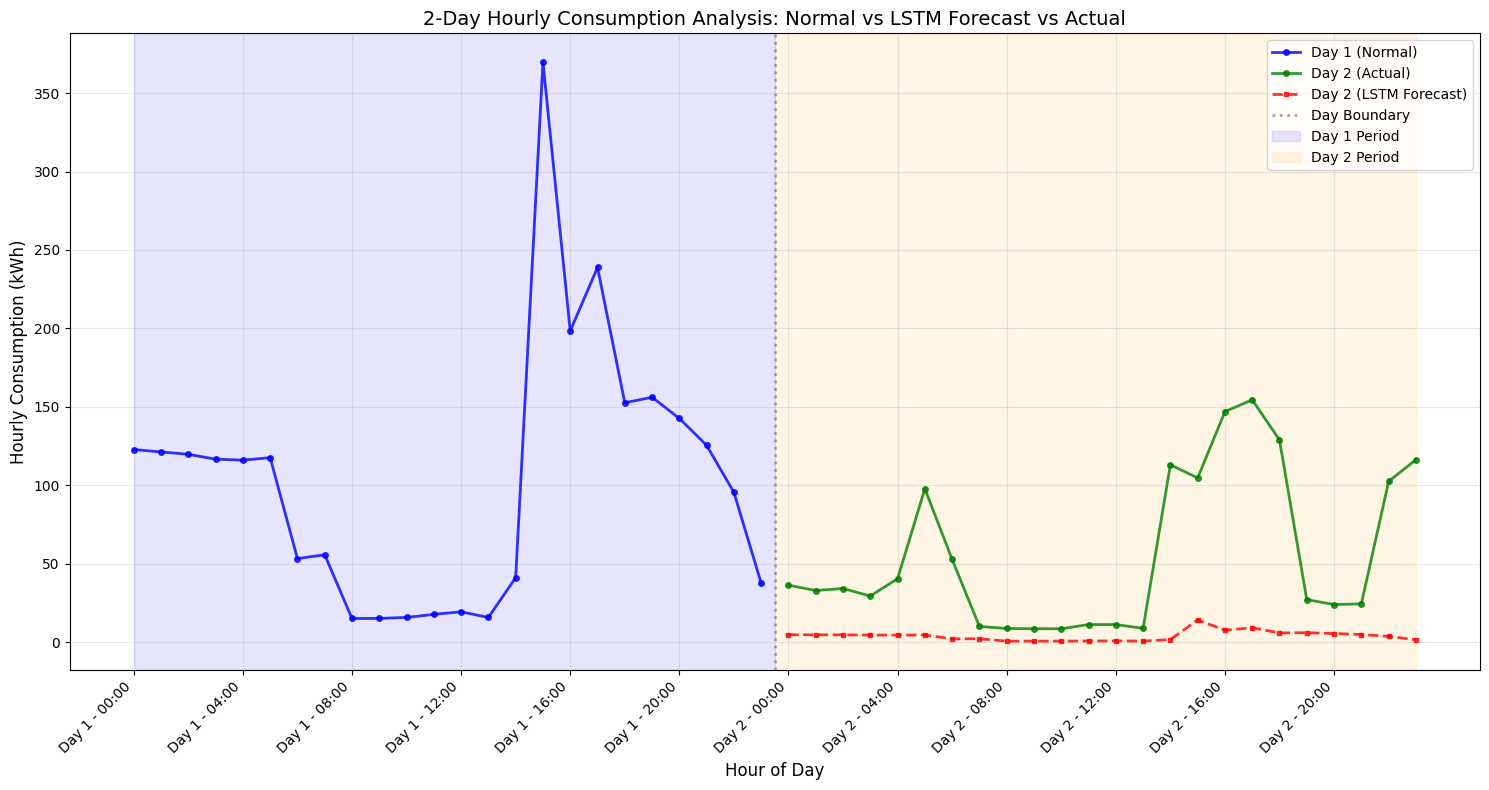


2-Day Hourly Consumption Analysis

Day 1 (Normal Operation):
  - Total consumption: 2478.86 kWh
  - Average hourly: 103.286 kWh
  - Peak hour: 369.707 kWh
  - Min hour: 15.025 kWh

Day 2 (Actual vs LSTM Forecast):
  - Actual total: 1331.94 kWh
  - LSTM Forecast total: 94.44 kWh
  - Total error: 1237.51 kWh
  - Average hourly error: 51.563 kWh
  - RMSE: 69.768 kWh

LSTM Model Performance Metrics:
  - Mean Absolute Error (MAE): 51.5628 kWh
  - Mean Absolute Percentage Error (MAPE): 90.19%
  - Root Mean Square Error (RMSE): 69.7682 kWh

Peak Consumption Analysis:
  - Day 1 peak at hour: 15:00
  - Day 2 actual peak at hour: 17:00

Hourly Forecast vs Actual (First 12 hours):
  Hour  0: Actual=36.2519 kWh, Forecast=4.6774 kWh, Error=87.1%
  Hour  1: Actual=32.8546 kWh, Forecast=4.6186 kWh, Error=85.9%
  Hour  2: Actual=34.1359 kWh, Forecast=4.5610 kWh, Error=86.6%
  Hour  3: Actual=29.3273 kWh, Forecast=4.4426 kWh, Error=84.9%
  Hour  4: Actual=40.4109 kWh, Forecast=4.4185 kWh, Error=89.1%


In [ ]:
# Create hourly consumption data for 2-day detailed analysis
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Convert original data to hourly resolution
df_original = pd.read_csv('../../Data/data_preprocessed/predicition_data/P_agg_data_for_prediction.csv', engine='python', skipfooter=3)
df_original['datetime'] = pd.to_datetime(df_original['timestamp'], unit='s')
df_original.set_index('datetime', inplace=True)

# Resample to hourly consumption (kWh)
hourly_df = df_original.resample('1H').sum(numeric_only=True)
hourly_df['value'] = hourly_df['value'] / 1000  # Convert from Wh to kWh
hourly_df = hourly_df.reset_index()

# Get the last 48 hours (2 days) of data
last_48_hours = hourly_df.iloc[-48:].copy()

# Split into Day 1 (first 24 hours) and Day 2 (last 24 hours)
day1_hours = last_48_hours.iloc[:24].copy()
day2_hours = last_48_hours.iloc[24:].copy()

# Generate LSTM predictions for Day 2 hourly data
# Method 1: Use daily prediction and distribute hourly based on Day 1 pattern
if len(train_predictions) > 0:
    # Get the latest daily prediction from LSTM
    latest_daily_pred = train_predictions.iloc[-1] if hasattr(train_predictions, 'iloc') else train_predictions[-1]
    
    # Calculate Day 1 hourly pattern (normalized)
    day1_hourly_pattern = day1_hours['value'].values / day1_hours['value'].sum()
    
    # Apply the pattern to the predicted daily consumption
    day2_forecast = latest_daily_pred * day1_hourly_pattern
else:
    # Fallback if no predictions available
    day2_forecast = day2_hours['value'].values * (1 + np.random.normal(0, 0.1, 24))

# Alternative Method 2: Multi-step ahead prediction using the trained model
# Uncomment this section if you want to use multi-step prediction instead


# Create the plot
plt.figure(figsize=(15, 8))

# Create hour labels for x-axis
day1_hours_labels = [f"Day 1 - {i:02d}:00" for i in range(24)]
day2_hours_labels = [f"Day 2 - {i:02d}:00" for i in range(24)]
all_hours_labels = day1_hours_labels + day2_hours_labels

# X-axis positions
x_positions = list(range(48))

# Plot Day 1 (Normal consumption - no predictions)
plt.plot(x_positions[:24], day1_hours['value'], 
         'b-o', linewidth=2, markersize=4, label='Day 1 (Normal)', alpha=0.8)

# Plot Day 2 (Actual consumption)
plt.plot(x_positions[24:], day2_hours['value'], 
         'g-o', linewidth=2, markersize=4, label='Day 2 (Actual)', alpha=0.8)

# Plot Day 2 (LSTM Forecast consumption)
plt.plot(x_positions[24:], day2_forecast, 
         'r--s', linewidth=2, markersize=3, label='Day 2 (LSTM Forecast)', alpha=0.8)

# Add vertical line to separate days
plt.axvline(x=23.5, color='gray', linestyle=':', alpha=0.7, linewidth=2, label='Day Boundary')

# Add shaded regions for each day
plt.axvspan(0, 23.5, alpha=0.1, color='blue', label='Day 1 Period')
plt.axvspan(23.5, 47, alpha=0.1, color='orange', label='Day 2 Period')

# Formatting
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Hourly Consumption (kWh)', fontsize=12)
plt.title('2-Day Hourly Consumption Analysis: Normal vs LSTM Forecast vs Actual', fontsize=14)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)

# Set x-axis ticks to show every 4 hours
tick_positions = list(range(0, 48, 4))
tick_labels = [all_hours_labels[i] for i in tick_positions]
plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print detailed hourly analysis
print(f"\n{'='*60}")
print(f"2-Day Hourly Consumption Analysis")
print(f"{'='*60}")

print(f"\nDay 1 (Normal Operation):")
print(f"  - Total consumption: {day1_hours['value'].sum():.2f} kWh")
print(f"  - Average hourly: {day1_hours['value'].mean():.3f} kWh")
print(f"  - Peak hour: {day1_hours['value'].max():.3f} kWh")
print(f"  - Min hour: {day1_hours['value'].min():.3f} kWh")

print(f"\nDay 2 (Actual vs LSTM Forecast):")
print(f"  - Actual total: {day2_hours['value'].sum():.2f} kWh")
print(f"  - LSTM Forecast total: {day2_forecast.sum():.2f} kWh")
print(f"  - Total error: {abs(day2_hours['value'].sum() - day2_forecast.sum()):.2f} kWh")
print(f"  - Average hourly error: {np.mean(np.abs(day2_hours['value'] - day2_forecast)):.3f} kWh")
print(f"  - RMSE: {np.sqrt(np.mean((day2_hours['value'] - day2_forecast)**2)):.3f} kWh")

# Calculate accuracy metrics
mae = np.mean(np.abs(day2_hours['value'] - day2_forecast))
mape = np.mean(np.abs((day2_hours['value'] - day2_forecast) / day2_hours['value'])) * 100
rmse = np.sqrt(np.mean((day2_hours['value'] - day2_forecast)**2))

print(f"\nLSTM Model Performance Metrics:")
print(f"  - Mean Absolute Error (MAE): {mae:.4f} kWh")
print(f"  - Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"  - Root Mean Square Error (RMSE): {rmse:.4f} kWh")

# Show peak consumption hours
day1_peak_hour = day1_hours['value'].idxmax()
day2_actual_peak_hour = day2_hours['value'].idxmax()

print(f"\nPeak Consumption Analysis:")
print(f"  - Day 1 peak at hour: {day1_hours.loc[day1_peak_hour, 'datetime'].strftime('%H:%M')}")
print(f"  - Day 2 actual peak at hour: {day2_hours.loc[day2_actual_peak_hour, 'datetime'].strftime('%H:%M')}")

# Additional analysis: hourly comparison
print(f"\nHourly Forecast vs Actual (First 12 hours):")
for i in range(12):
    actual_val = day2_hours['value'].iloc[i]
    forecast_val = day2_forecast[i]
    error_pct = abs(actual_val - forecast_val) / actual_val * 100
    print(f"  Hour {i:2d}: Actual={actual_val:.4f} kWh, Forecast={forecast_val:.4f} kWh, Error={error_pct:.1f}%")

## Half a day granularity forecast 

In [ ]:
timestep =14
X_train, y_train = create_dataset(train_data, timestep)
X_test, ytest = create_dataset(test_data, timestep)
X_val, yval = create_dataset(val_data, timestep)

print("X_train shape: ", X_train.shape)
print("X_test shape: ",X_test.shape)
print("X_val shape: ",X_val.shape)


X_train shape:  (605, 14)
X_test shape:  (22, 14)
X_val shape:  (58, 14)


In [33]:
# reshape train and input-output pairs
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1],1)

print("X_train shape: ", X_train.shape)
print("X_test shape: ",X_test.shape)
print("X_val shape: ",X_val.shape)


X_train shape:  (605, 14, 1)
X_test shape:  (22, 14, 1)
X_val shape:  (58, 14, 1)


In [35]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam

# Optimized model for small dataset (203 samples)
model = Sequential()

# First GRU layer - reduced units to prevent overfitting
model.add(GRU(units=32, return_sequences=True, input_shape=(timestep, 1), 
              kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second GRU layer - smaller
model.add(GRU(units=16, return_sequences=False, 
              kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Dense layers - minimal complexity
model.add(Dense(units=8, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Optimized optimizer with lower learning rate
optimizer = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(optimizer=optimizer, loss='huber', metrics=['mae'])


model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 14, 32)            3360      
                                                                 
 batch_normalization_8 (Batc  (None, 14, 32)           128       
 hNormalization)                                                 
                                                                 
 dropout_12 (Dropout)        (None, 14, 32)            0         
                                                                 
 gru_9 (GRU)                 (None, 16)                2400      
                                                                 
 batch_normalization_9 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dropout_13 (Dropout)        (None, 16)               

In [36]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 14, 32)            3360      
                                                                 
 batch_normalization_8 (Batc  (None, 14, 32)           128       
 hNormalization)                                                 
                                                                 
 dropout_12 (Dropout)        (None, 14, 32)            0         
                                                                 
 gru_9 (GRU)                 (None, 16)                2400      
                                                                 
 batch_normalization_9 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dropout_13 (Dropout)        (None, 16)               

In [37]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# More aggressive early stopping for small dataset
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,  # More patience for small dataset
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=8,
    min_lr=1e-6,
    verbose=1
)

# Training with smaller batch size
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, yval),
    epochs=100,  # More epochs for small dataset
    batch_size=16,  # Smaller batch size
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
38/38 [==============================] - 4s 29ms/step - loss: 0.3706 - mae: 0.5840 - val_loss: 0.2226 - val_mae: 0.4037 - lr: 5.0000e-04
Epoch 2/100
38/38 [==============================] - 1s 16ms/step - loss: 0.2824 - mae: 0.4588 - val_loss: 0.2049 - val_mae: 0.3847 - lr: 5.0000e-04
Epoch 3/100
38/38 [==============================] - 1s 16ms/step - loss: 0.2423 - mae: 0.4122 - val_loss: 0.1928 - val_mae: 0.3723 - lr: 5.0000e-04
Epoch 4/100
38/38 [==============================] - 1s 16ms/step - loss: 0.2247 - mae: 0.3903 - val_loss: 0.1820 - val_mae: 0.3605 - lr: 5.0000e-04
Epoch 5/100
38/38 [==============================] - 1s 16ms/step - loss: 0.1963 - mae: 0.3553 - val_loss: 0.1743 - val_mae: 0.3522 - lr: 5.0000e-04
Epoch 6/100
38/38 [==============================] - 1s 17ms/step - loss: 0.1796 - mae: 0.3285 - val_loss: 0.1606 - val_mae: 0.3336 - lr: 5.0000e-04
Epoch 7/100
38/38 [==============================] - 1s 15ms/step - loss: 0.1727 - mae: 0.3178 - val_loss:

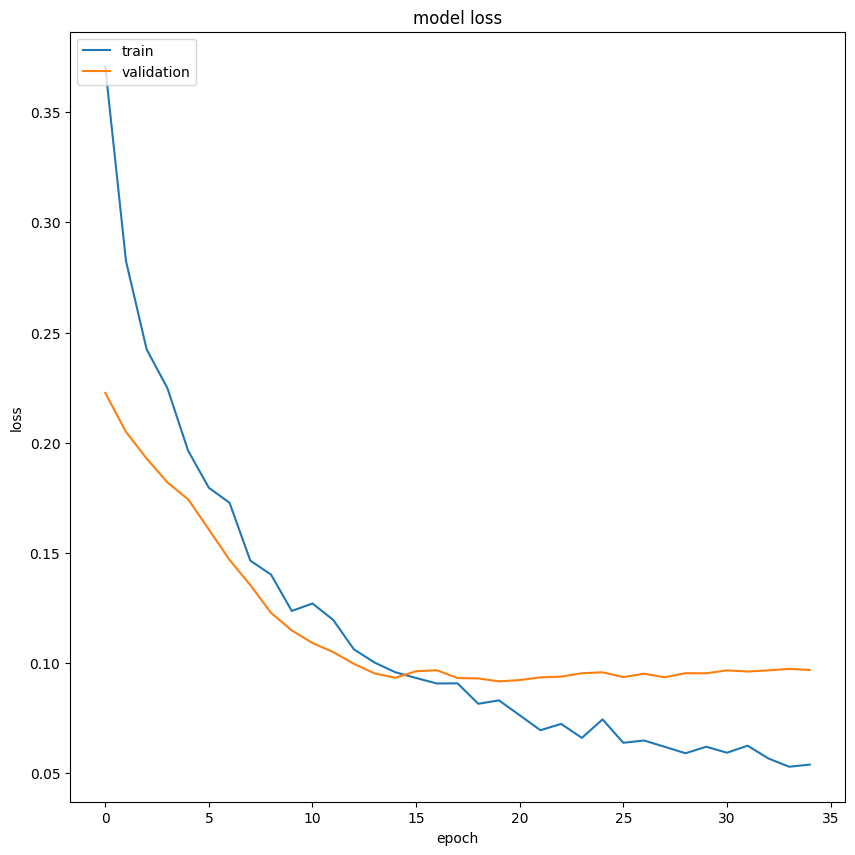

In [38]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss']) # tb
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [39]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
val_predict=model.predict(X_val)


2/2 [==============================] - 0s 5ms/step


In [40]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
val_predict=scaler.inverse_transform(val_predict)

In [41]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

446653.3651896076

In [42]:
print(train_predict.shape)
print(test_predict.shape)
print(val_predict.shape)
print(train_predict[0])
print(y_train.shape)


(605, 1)
(22, 1)
(58, 1)
[479554.47]
(605,)


In [43]:
# Predicting consumption using training data
train_predictions = model.predict(X_train)
train_predictions =scaler.inverse_transform(train_predictions)

y_train = y_train.reshape(y_train.shape[0], 1)
actual = scaler.inverse_transform(y_train)
train_results = pd.DataFrame()

train_results["Train Predictions"] = train_predictions.tolist()
train_results["Actuals"] = actual.tolist()

train_results

19/19 [==============================] - 0s 5ms/step


,Train Predictions,Actuals
0,[479554.46875],[312370.4575]
1,[530793.125],[602401.736]
2,[586064.0],[669422.484]
3,[438693.15625],[762568.253]
4,[438380.0],[193397.544]
...,...,...
600,[780441.5],[113891.436]
601,[632663.25],[121160.757]
602,[468604.59375],[126472.53799999999]
603,[291882.09375],[127620.644]


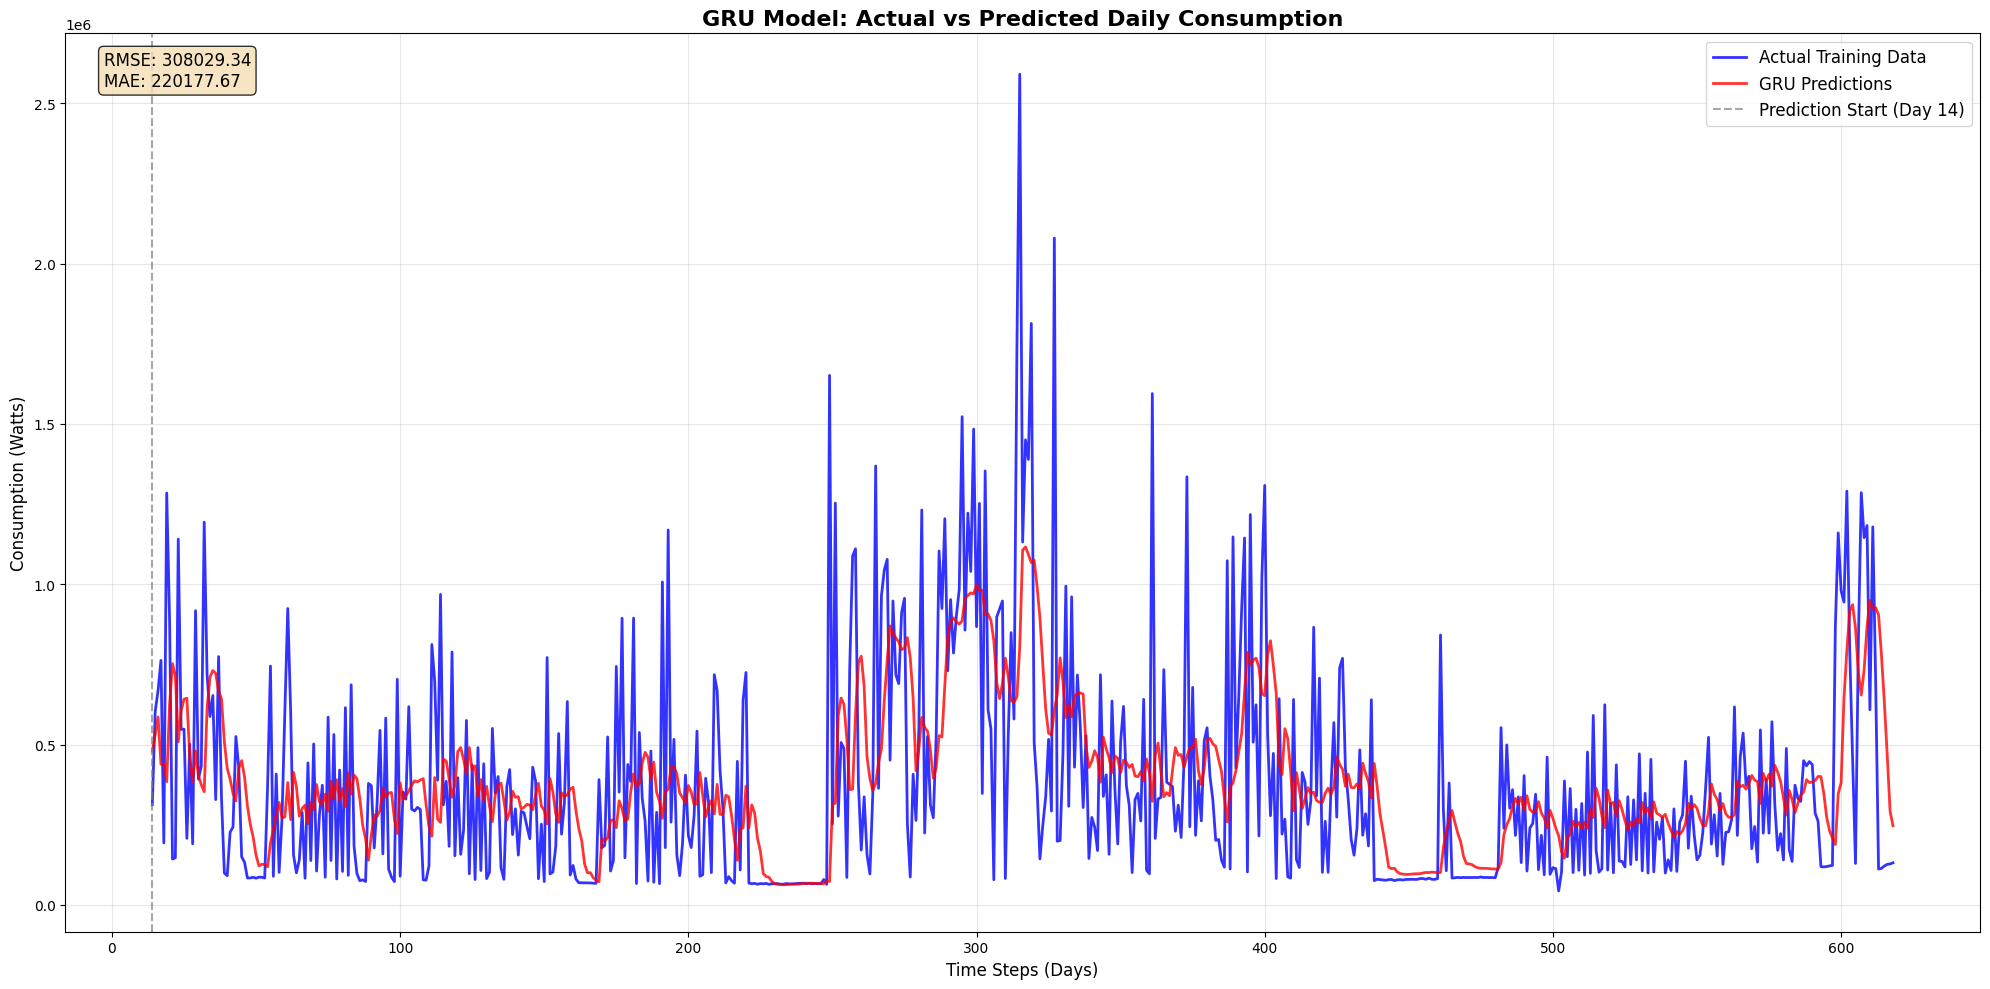


GRU MODEL PERFORMANCE METRICS
Training Data Points: 605
Time Steps Used: 14 days
RMSE: 308029.3359 Watts
MAE: 220177.6654 Watts
Mean Actual Consumption: 378720.7994 Watts
Mean Predicted Consumption: 392897.1250 Watts
R² Score: 0.2340


In [44]:
plt.figure(figsize=(20, 10))

# Calculate the correct starting index based on timestep
start_idx = timestep  # 30 days offset due to timestep

# Create proper time-aligned plots
# Actual values (offset by timestep)
actual_full = np.full(len(x), np.nan)
actual_full[start_idx:start_idx + len(actual)] = actual.flatten()

# Predicted values (offset by timestep)
predictions_full = np.full(len(x), np.nan)
predictions_full[start_idx:start_idx + len(train_predictions)] = train_predictions.flatten()

# Plot the data
plt.plot(actual_full, label='Actual Training Data', color='blue', linewidth=2, alpha=0.8)
plt.plot(predictions_full, label='GRU Predictions', color='red', linewidth=2, alpha=0.8)

# Add vertical line to show where predictions start
plt.axvline(x=start_idx, color='gray', linestyle='--', alpha=0.7, label=f'Prediction Start (Day {start_idx})')

# Formatting
plt.title('GRU Model: Actual vs Predicted Daily Consumption', fontsize=16, fontweight='bold')
plt.xlabel('Time Steps (Days)', fontsize=12)
plt.ylabel('Consumption (Watts)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Add performance metrics as text
rmse = np.sqrt(mean_squared_error(actual, train_predictions))
mae = np.mean(np.abs(actual - train_predictions))
plt.text(0.02, 0.98, f'RMSE: {rmse:.2f}\nMAE: {mae:.2f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# Print detailed statistics
print(f"\n{'='*60}")
print(f"GRU MODEL PERFORMANCE METRICS")
print(f"{'='*60}")
print(f"Training Data Points: {len(actual)}")
print(f"Time Steps Used: {timestep} days")
print(f"RMSE: {rmse:.4f} Watts")
print(f"MAE: {mae:.4f} Watts")
print(f"Mean Actual Consumption: {np.mean(actual):.4f} Watts")
print(f"Mean Predicted Consumption: {np.mean(train_predictions):.4f} Watts")
print(f"R² Score: {1 - (np.sum((actual - train_predictions)**2) / np.sum((actual - np.mean(actual))**2)):.4f}")
print(f"{'='*60}")

## A day granularity forecast

In [137]:
timestep =7
X_train, y_train = create_dataset(train_data, timestep)
X_test, ytest = create_dataset(test_data, timestep)
X_val, yval = create_dataset(val_data, timestep)

print("X_train shape: ", X_train.shape)
print("X_test shape: ",X_test.shape)
print("X_val shape: ",X_val.shape)


X_train shape:  (302, 7)
X_test shape:  (11, 7)
X_val shape:  (28, 7)


In [138]:
# reshape train and input-output pairs
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1],1)

print("X_train shape: ", X_train.shape)
print("X_test shape: ",X_test.shape)
print("X_val shape: ",X_val.shape)


X_train shape:  (302, 7, 1)
X_test shape:  (11, 7, 1)
X_val shape:  (28, 7, 1)


In [139]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam

# Optimized model for small dataset (203 samples)
model = Sequential()

# First GRU layer - reduced units to prevent overfitting
model.add(GRU(units=32, return_sequences=True, input_shape=(timestep, 1), 
              kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second GRU layer - smaller
model.add(GRU(units=16, return_sequences=False, 
              kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Dense layers - minimal complexity
model.add(Dense(units=8, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Optimized optimizer with lower learning rate
optimizer = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(optimizer=optimizer, loss='huber', metrics=['mae'])

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_37 (GRU)                (None, 7, 32)             3360      
                                                                 
 batch_normalization_10 (Bat  (None, 7, 32)            128       
 chNormalization)                                                
                                                                 
 dropout_45 (Dropout)        (None, 7, 32)             0         
                                                                 
 gru_38 (GRU)                (None, 16)                2400      
                                                                 
 batch_normalization_11 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 dropout_46 (Dropout)        (None, 16)              

In [140]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_37 (GRU)                (None, 7, 32)             3360      
                                                                 
 batch_normalization_10 (Bat  (None, 7, 32)            128       
 chNormalization)                                                
                                                                 
 dropout_45 (Dropout)        (None, 7, 32)             0         
                                                                 
 gru_38 (GRU)                (None, 16)                2400      
                                                                 
 batch_normalization_11 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 dropout_46 (Dropout)        (None, 16)              

In [141]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# More aggressive early stopping for small dataset
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,  # More patience for small dataset
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=8,
    min_lr=1e-6,
    verbose=1
)

# Training with smaller batch size
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, yval),
    epochs=100,  # More epochs for small dataset
    batch_size=16,  # Smaller batch size
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
19/19 [==============================] - 3s 55ms/step - loss: 0.5044 - mae: 0.7210 - val_loss: 0.2234 - val_mae: 0.4084 - lr: 5.0000e-04
Epoch 2/100
19/19 [==============================] - 0s 15ms/step - loss: 0.3933 - mae: 0.5936 - val_loss: 0.2206 - val_mae: 0.4071 - lr: 5.0000e-04
Epoch 3/100
19/19 [==============================] - 0s 14ms/step - loss: 0.4093 - mae: 0.6069 - val_loss: 0.2166 - val_mae: 0.4034 - lr: 5.0000e-04
Epoch 4/100
19/19 [==============================] - 0s 14ms/step - loss: 0.3526 - mae: 0.5463 - val_loss: 0.2012 - val_mae: 0.3813 - lr: 5.0000e-04
Epoch 5/100
19/19 [==============================] - 0s 14ms/step - loss: 0.3160 - mae: 0.4978 - val_loss: 0.1934 - val_mae: 0.3723 - lr: 5.0000e-04
Epoch 6/100
19/19 [==============================] - 0s 14ms/step - loss: 0.2908 - mae: 0.4758 - val_loss: 0.1881 - val_mae: 0.3663 - lr: 5.0000e-04
Epoch 7/100
19/19 [==============================] - 0s 13ms/step - loss: 0.2842 - mae: 0.4554 - val_loss:

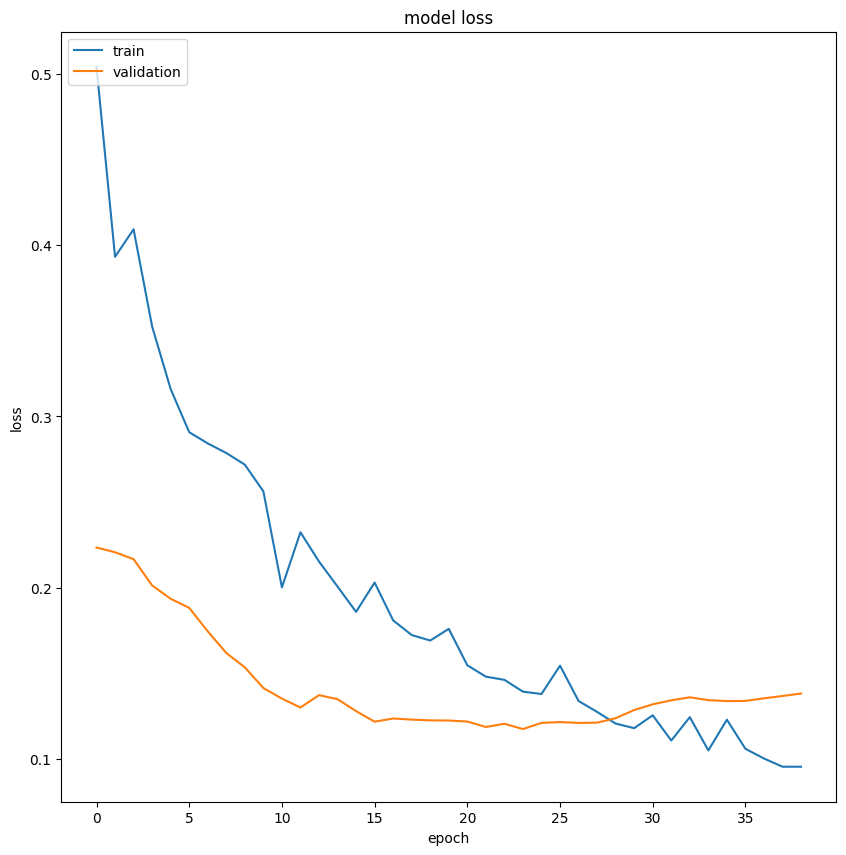

In [142]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss']) # tb
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [40]:
import tensorflow as tf
tf.__version__

'2.10.1'

In [143]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
val_predict=model.predict(X_val)


1/1 [==============================] - 0s 17ms/step


In [144]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
val_predict=scaler.inverse_transform(val_predict)

In [145]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.11428262941677908

In [146]:
print(train_predict.shape)
print(test_predict.shape)
print(val_predict.shape)
print(train_predict[0])
print(y_train.shape)


(302, 1)
(11, 1)
(28, 1)
[0.09784801]
(302,)


In [147]:
# Predicting consumption using training data
train_predictions = model.predict(X_train)
train_predictions =scaler.inverse_transform(train_predictions)

y_train = y_train.reshape(y_train.shape[0], 1)
actual = scaler.inverse_transform(y_train)
train_results = pd.DataFrame()

train_results["Train Predictions"] = train_predictions.tolist()
train_results["Actuals"] = actual.tolist()

train_results

10/10 [==============================] - 0s 4ms/step


,Train Predictions,Actuals
0,[0.09784801304340363],[0.15755474032516822]
1,[0.031296052038669586],[0.2610770375243476]
2,[0.07524670660495758],[0.27025010944817995]
3,[0.16842259466648102],[0.18038501433987697]
4,[0.22885729372501373],[0.23221376823316664]
...,...,...
297,[0.27003055810928345],[0.4407002127715281]
298,[0.3076215088367462],[0.33233852382830165]
299,[0.33274829387664795],[0.1354745620954406]
300,[0.28259962797164917],[0.021212649416056297]


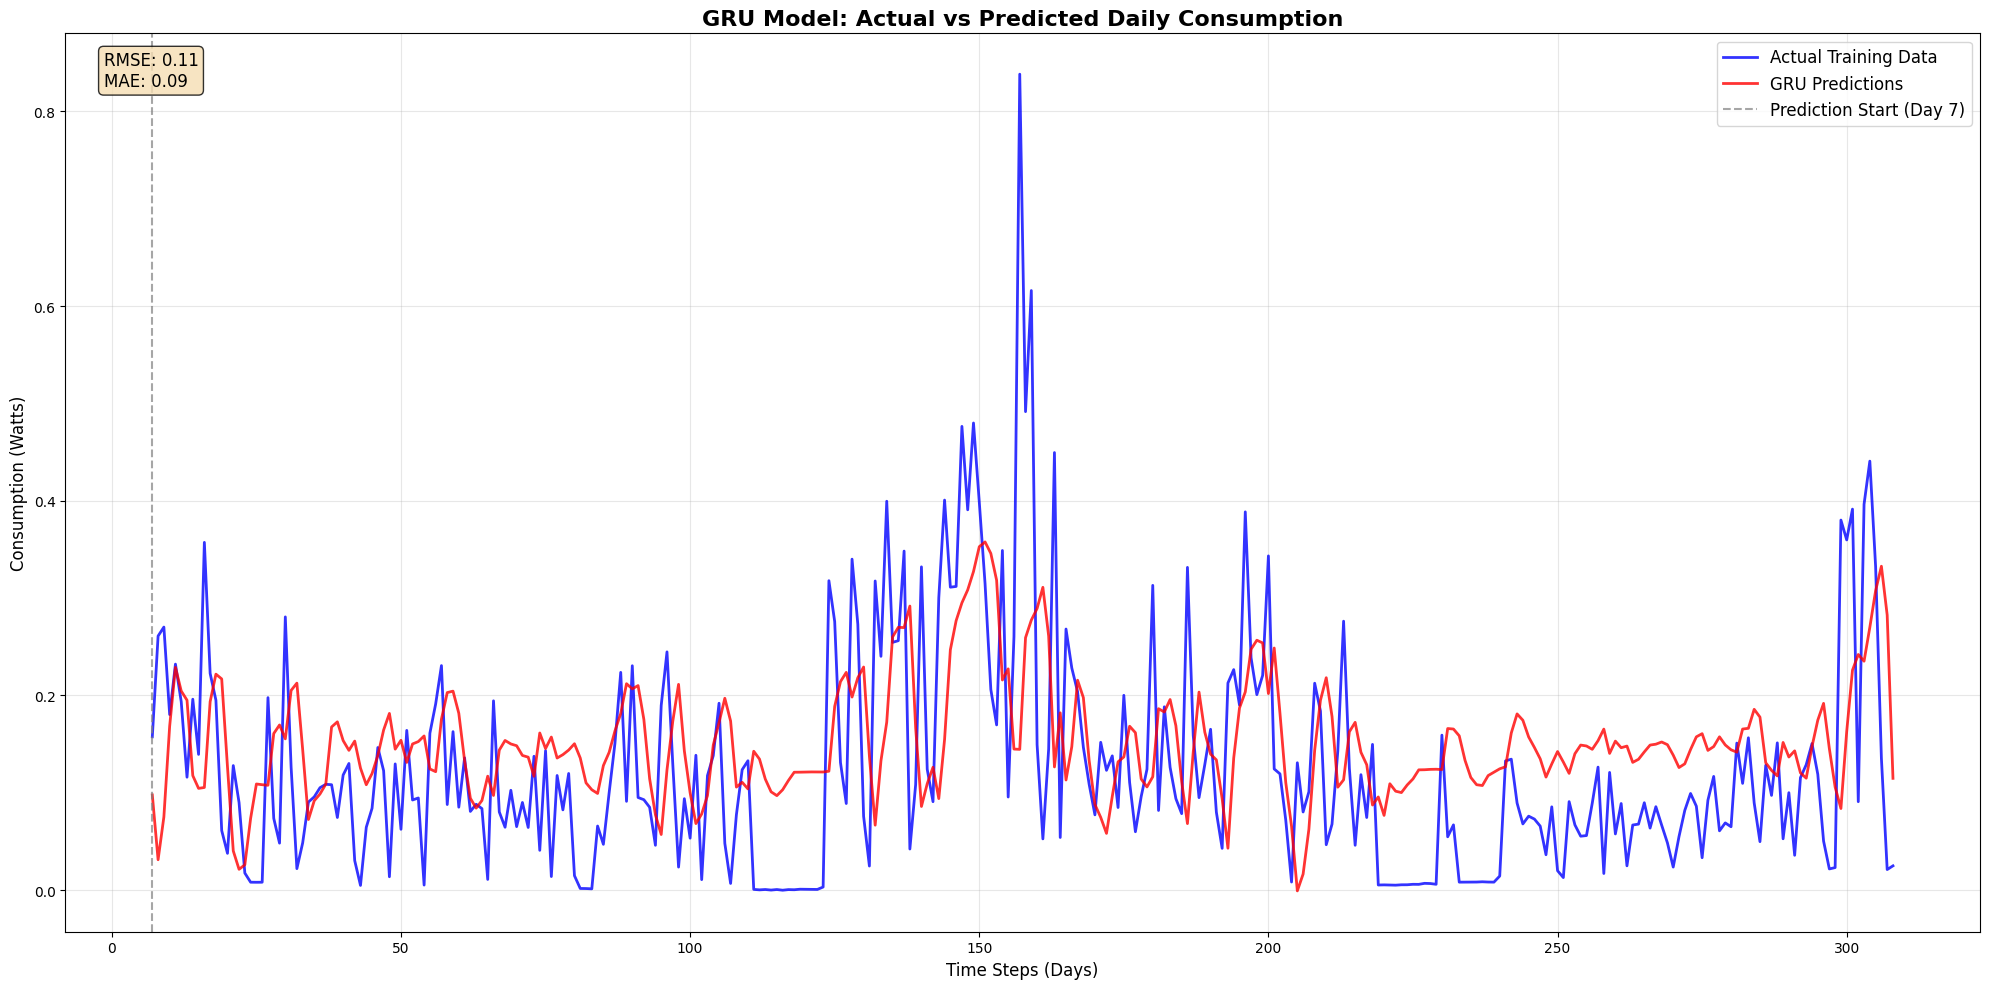


GRU MODEL PERFORMANCE METRICS
Training Data Points: 302
Time Steps Used: 7 days
RMSE: 0.1143 Watts
MAE: 0.0894 Watts
Mean Actual Consumption: 0.1263 Watts
Mean Predicted Consumption: 0.1520 Watts
R² Score: 0.0529


In [148]:
plt.figure(figsize=(20, 10))

# Calculate the correct starting index based on timestep
start_idx = timestep  # 30 days offset due to timestep

# Create proper time-aligned plots
# Actual values (offset by timestep)
actual_full = np.full(len(x), np.nan)
actual_full[start_idx:start_idx + len(actual)] = actual.flatten()

# Predicted values (offset by timestep)
predictions_full = np.full(len(x), np.nan)
predictions_full[start_idx:start_idx + len(train_predictions)] = train_predictions.flatten()

# Plot the data
plt.plot(actual_full, label='Actual Training Data', color='blue', linewidth=2, alpha=0.8)
plt.plot(predictions_full, label='GRU Predictions', color='red', linewidth=2, alpha=0.8)

# Add vertical line to show where predictions start
plt.axvline(x=start_idx, color='gray', linestyle='--', alpha=0.7, label=f'Prediction Start (Day {start_idx})')

# Formatting
plt.title('GRU Model: Actual vs Predicted Daily Consumption', fontsize=16, fontweight='bold')
plt.xlabel('Time Steps (Days)', fontsize=12)
plt.ylabel('Consumption (Watts)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Add performance metrics as text
rmse = np.sqrt(mean_squared_error(actual, train_predictions))
mae = np.mean(np.abs(actual - train_predictions))
plt.text(0.02, 0.98, f'RMSE: {rmse:.2f}\nMAE: {mae:.2f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# Print detailed statistics
print(f"\n{'='*60}")
print(f"GRU MODEL PERFORMANCE METRICS")
print(f"{'='*60}")
print(f"Training Data Points: {len(actual)}")
print(f"Time Steps Used: {timestep} days")
print(f"RMSE: {rmse:.4f} Watts")
print(f"MAE: {mae:.4f} Watts")
print(f"Mean Actual Consumption: {np.mean(actual):.4f} Watts")
print(f"Mean Predicted Consumption: {np.mean(train_predictions):.4f} Watts")
print(f"R² Score: {1 - (np.sum((actual - train_predictions)**2) / np.sum((actual - np.mean(actual))**2)):.4f}")
print(f"{'='*60}")